## benchmarking on sushmita ROY's dataset


In [1]:
from scprint import scPrint
from scdataloader import Preprocessor
from scprint.tasks import GRNfer

from bengrn import BenGRN, get_sroy_gt, unnormalize
import scanpy as sc
from bengrn.base import train_classifier

from anndata.utils import make_index_unique
from bengrn import compute_genie3
from grnndata import utils as grnutils
import numpy as np
import joblib

%load_ext autoreload
%autoreload 2 

import torch
torch.set_float32_matmul_precision('medium')

💡 connected lamindb: jkobject/scprint


/pasteur/appa/homes/jkalfon/miniconda3/envs/scprint17/lib/python3.10/site-packages/umap/__init__.py:9: ImportWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  warn(


In [2]:
# '../../data/main/gene_embeddings.parquet')
MAXGENES = 5000
MAXCELLS = 1024
model = scPrint.load_from_checkpoint(
    '/pasteur/zeus/projets/p02/ml4ig_hot/Users/jkalfon/scprint_scale/o2uniqsx/checkpoints/epoch=18-step=133000.ckpt', precpt_gene_emb=None, )#organisms=['NCBITaxon:9606','NCBITaxon:10090'])
metrics = {}


2024-06-27 14:06:36,807:INFO - Created a temporary directory at /local/scratch/tmp/tmpal1fyqa_


2024-06-27 14:06:36,808:INFO - Writing /local/scratch/tmp/tmpal1fyqa_/_remote_module_non_scriptable.py


RuntimeError caught: scPrint is not attached to a `Trainer`.


In [3]:
preprocessor = Preprocessor(is_symbol=True, force_preprocess=True, skip_validate=True,do_postp=False, min_valid_genes_id=MAXGENES, min_dataset_size=64)

# han / human

In [4]:
preadata = get_sroy_gt(get="han", species="human", gt="full")
adata = preprocessor(preadata.copy())
adata.var["isTF"] = False
adata.var.loc[adata.var.symbol.isin(grnutils.TF), "isTF"] = True
preadata, (preadata.grn.sum(1) != 0).sum()

Dropping layers:  KeysView(Layers with keys: )
checking raw counts
removed 0 non primary cells, 5520 renamining


filtered out 0 cells, 5520 renamining


Removed 0 genes.


startin QC


Seeing 151 outliers (2.74% of total dataset):
done


(GRnnData object with n_obs × n_vars = 5520 × 7465
     obs: 'organism_ontology_term_id'
     varp: 'GRN'
     with a grn of 8463 elements,
 31)

In [5]:
grn_inferer = GRNfer(model, adata,
                     how="most var within",
                     genes=adata.var[adata.var.symbol.isin(preadata.var[preadata.grn.sum(1) != 0].index.tolist())].index.tolist(),
                     preprocess="softmax",
                     head_agg='none',
                     filtration="none",
                     forward_mode="none",
                     organisms=['NCBITaxon:9606','NCBITaxon:10090'],
                     apc=False,
                     symmetrize=False,
                     num_genes=MAXGENES,
                     max_cells=MAXCELLS,
                     doplot=False,
                     batch_size=32,
                     )
grn = grn_inferer(layer=list(range(model.nlayers))[:])

Using 16bit Automatic Mixed Precision (AMP)


GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


number of expressed genes in this cell type: 7295


/pasteur/appa/homes/jkalfon/scPRINT/scprint/tasks/grn.py:165: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  organisms=[subadata.obs['organism_ontology_term_id'][0]],


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


SLURM auto-requeueing enabled. Setting signal handlers.


Predicting: |          | 0/? [00:00<?, ?it/s]

In [6]:
grn.varp["all"] = grn.varp['GRN']
grn.var['ensembl_id'] = grn.var.index
grn.var['symbol'] = make_index_unique(grn.var['symbol'].astype(str))
grn.var.index = grn.var['symbol']

precision:  0.038948387096774194 
recall:  1.0 
random precision: 0.03895617833244068



  0%|          | 0/128 [00:00<?, ?it/s]

/pasteur/appa/homes/jkalfon/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()

100%|██████████| 128/128 [00:00<00:00, 1941.24it/s]

Area Under Precision-Recall Curve (AUPRC):  0.040911006732137586
EPR: 1.1764152910621384


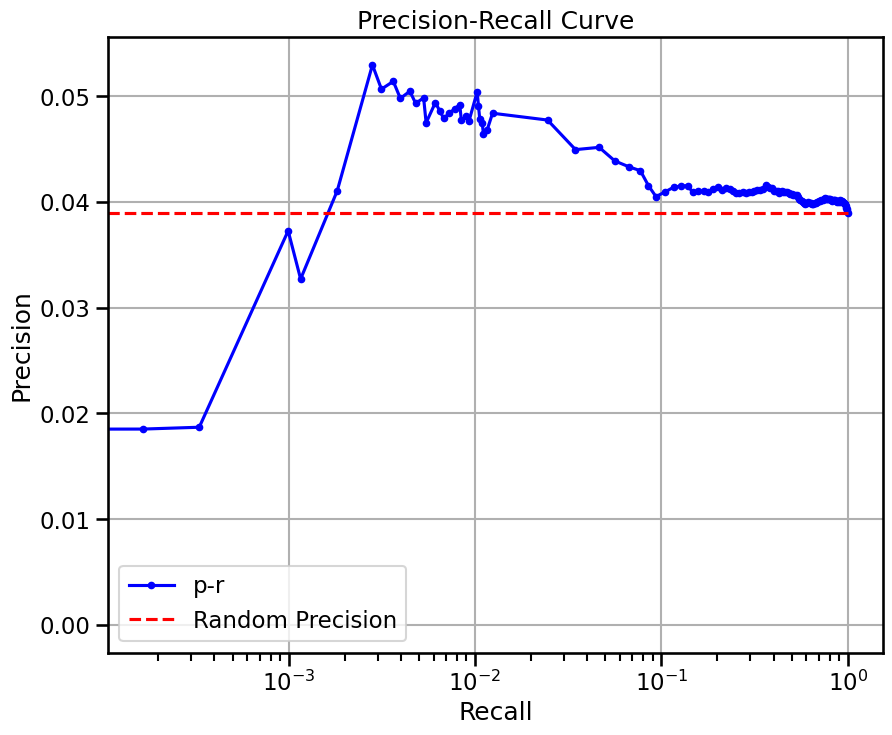

In [7]:
grn.varp['GRN'] = grn.varp['all'].mean(-1)
metrics['scprint_mean_han_full'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

base enrichment


Top central genes: []


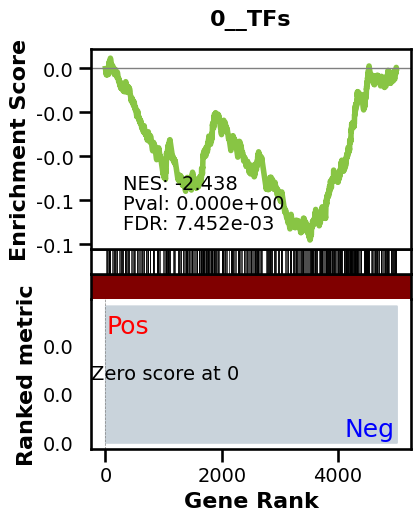

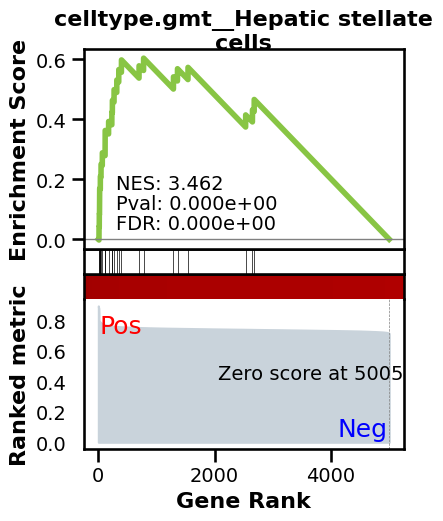

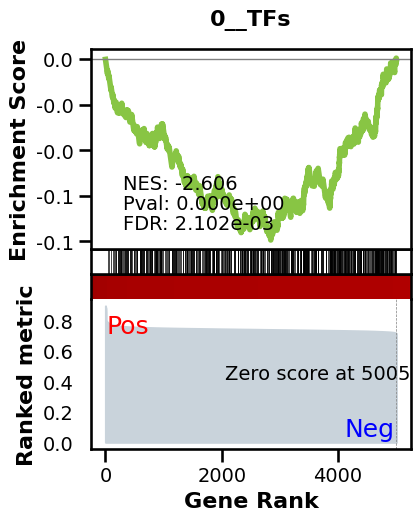

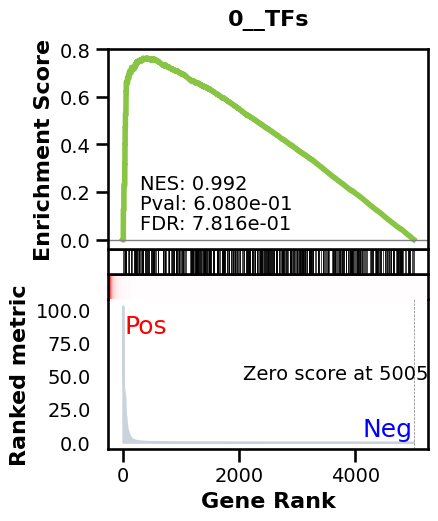

_________________________________________
TF specific enrichment


found some significant results for  23.636363636363637 % TFs

_________________________________________
loading GT,  omnipath


intersection of 3767 genes
intersection pct: 0.7524970035956852
precision:  0.0016151890916386552 
recall:  1.0 
random precision: 0.001615617978811156



  0%|          | 0/128 [00:00<?, ?it/s]


  4%|▍         | 5/128 [00:00<00:02, 46.05it/s]


  8%|▊         | 10/128 [00:00<00:02, 45.77it/s]


 12%|█▏        | 15/128 [00:00<00:02, 45.61it/s]


 16%|█▌        | 20/128 [00:00<00:02, 45.50it/s]


 20%|█▉        | 25/128 [00:00<00:02, 45.70it/s]


 23%|██▎       | 30/128 [00:00<00:02, 45.51it/s]


 27%|██▋       | 35/128 [00:00<00:02, 45.48it/s]


 31%|███▏      | 40/128 [00:00<00:01, 45.59it/s]


 35%|███▌      | 45/128 [00:00<00:01, 45.62it/s]


 39%|███▉      | 50/128 [00:01<00:01, 45.57it/s]


 43%|████▎     | 55/128 [00:01<00:01, 45.52it/s]


 47%|████▋     | 60/128 [00:01<00:01, 45.67it/s]


 51%|█████     | 65/128 [00:01<00:01, 45.58it/s]


 55%|█████▍    | 70/128 [00:01<00:01, 45.57it/s]


 59%|█████▊    | 75/128 [00:01<00:01, 45.53it/s]


 62%|██████▎   | 80/128 [00:01<00:01, 45.73it/s]


 66%|██████▋   | 85/128 [00:01<00:00, 45.62it/s]


 70%|███████   | 90/128 [00:01<00:00, 45.57it/s]


 74%|███████▍  | 95/128 [00:02<00:00, 45.59it/s]


 78%|███████▊  | 100/128 [00:02<00:00, 45.62it/s]


 82%|████████▏ | 105/128 [00:02<00:00, 45.56it/s]


 86%|████████▌ | 110/128 [00:02<00:00, 45.49it/s]


 90%|████████▉ | 115/128 [00:02<00:00, 45.77it/s]


 94%|█████████▍| 120/128 [00:02<00:00, 45.68it/s]


 98%|█████████▊| 125/128 [00:02<00:00, 45.57it/s]

/pasteur/appa/homes/jkalfon/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()

100%|██████████| 128/128 [00:02<00:00, 45.56it/s]

Area Under Precision-Recall Curve (AUPRC):  0.0018056727840080483


EPR: 2.0321305173018605


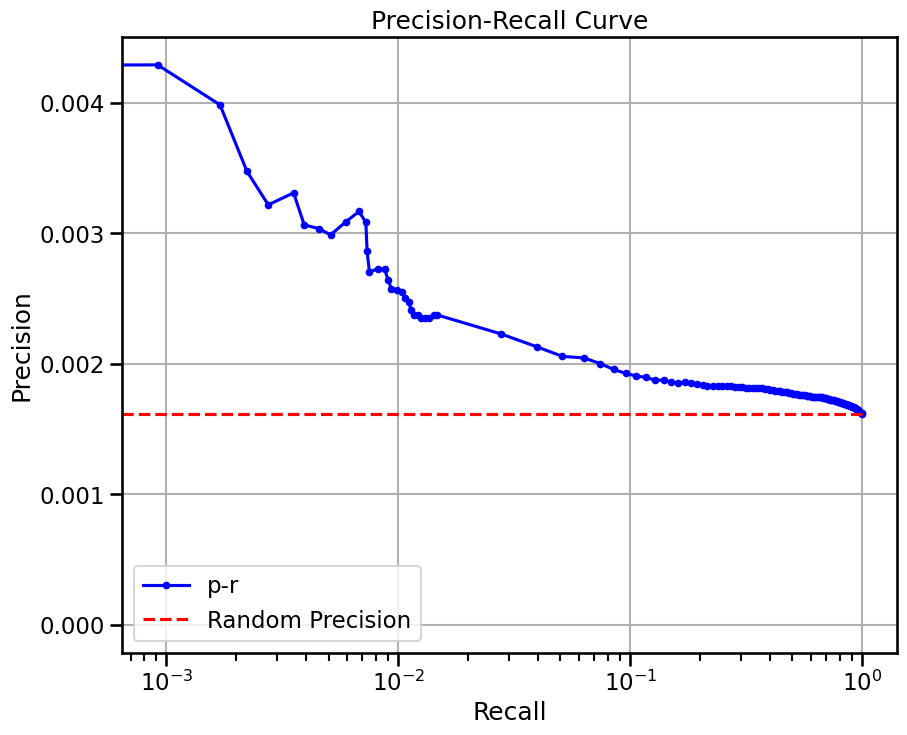

In [8]:
metrics['scprint_mean_han_base'] = BenGRN(grn, do_auc=True, doplot=True).scprint_benchmark()

precision:  0.264192 
recall:  1.0 
random precision: 0.26424484896979394



  0%|          | 0/128 [00:00<?, ?it/s]


 37%|███▋      | 47/128 [00:00<00:00, 469.27it/s]


 73%|███████▎  | 94/128 [00:00<00:00, 469.16it/s]

/pasteur/appa/homes/jkalfon/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()

100%|██████████| 128/128 [00:00<00:00, 468.13it/s]

Area Under Precision-Recall Curve (AUPRC):  0.2711089643172445
EPR: 1.062011064568394


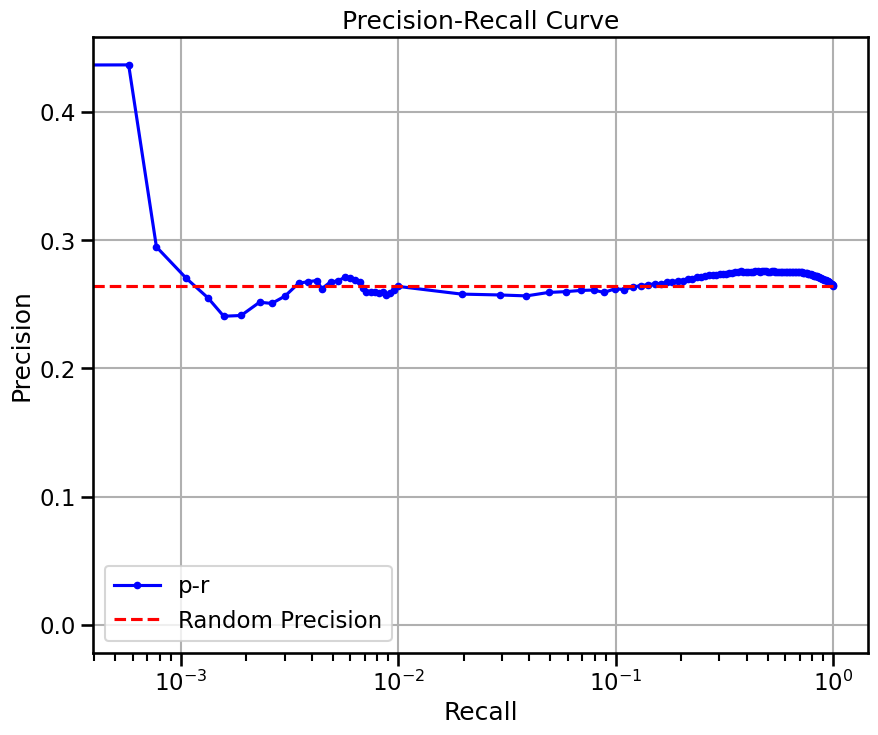

In [9]:
preadata = get_sroy_gt(get="han", species="human", gt="chip")
metrics['scprint_mean_han_chip'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

precision:  0.08270819672131148 
recall:  1.0 
random precision: 0.0827247416696454



  0%|          | 0/128 [00:00<?, ?it/s]


 31%|███▏      | 40/128 [00:00<00:00, 395.09it/s]


 62%|██████▎   | 80/128 [00:00<00:00, 395.28it/s]


 94%|█████████▍| 120/128 [00:00<00:00, 395.85it/s]

/pasteur/appa/homes/jkalfon/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()

100%|██████████| 128/128 [00:00<00:00, 394.98it/s]

Area Under Precision-Recall Curve (AUPRC):  0.08625428908960658
EPR: 1.096315172693967


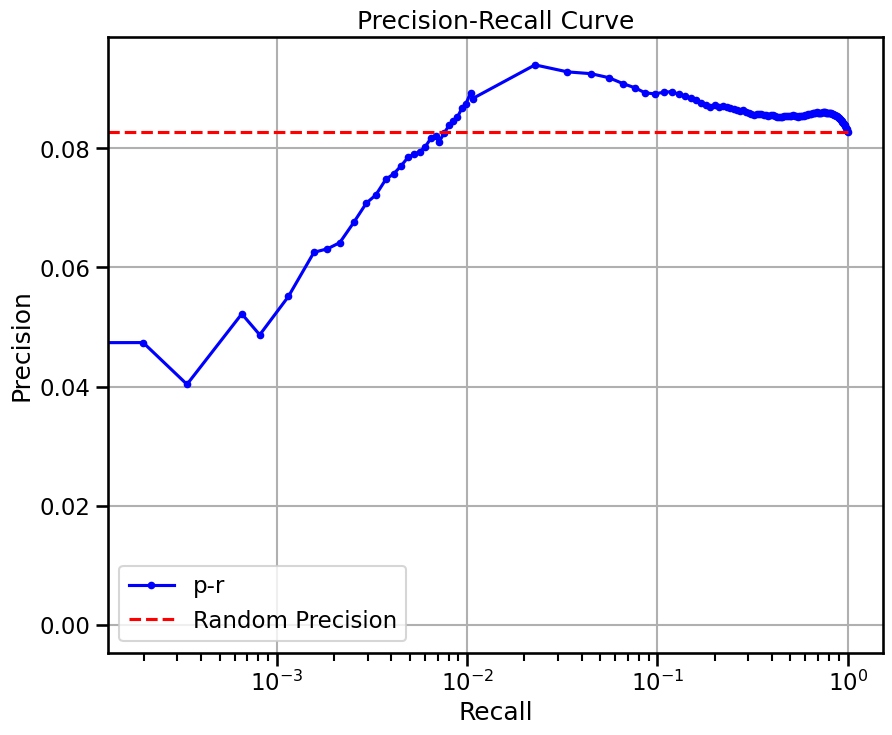

In [10]:
preadata = get_sroy_gt(get="han", species="human", gt="ko")
metrics['scprint_mean_han_ko'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

In [11]:
preadata = get_sroy_gt(get="han", species="human", gt="full")

true elem 22920 ...


doing classification....


metrics {'used_heads': 101, 'precision': 0.005585292064230859, 'random_precision': 0.00165958553348804, 'recall': 0.01019108280254777, 'predicted_true': 4297.0, 'number_of_true': 2355.0, 'epr': 3.874463072539996}


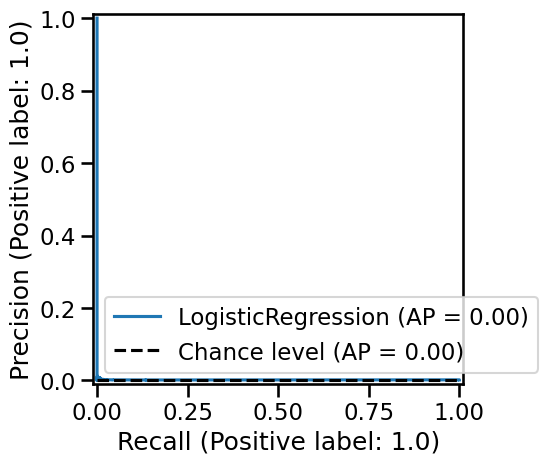

In [12]:
grn.varp["GRN"] = grn.varp['all']
grn, m, clf_omni = train_classifier(grn, C=0.1, train_size=0.9, class_weight={1: 200, 0: 1}, shuffle=True)

In [13]:
# Save the clf_omni classifier to a file
joblib.dump(clf_omni, 'clf_omni_model.pkl')

['clf_omni_model.pkl']

precision:  0.038948387096774194 
recall:  1.0 
random precision: 0.03895617833244068



  0%|          | 0/128 [00:00<?, ?it/s]

/pasteur/appa/homes/jkalfon/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()

100%|██████████| 128/128 [00:00<00:00, 2164.57it/s]

Area Under Precision-Recall Curve (AUPRC):  0.035703242904874116
EPR: 0.5285884349921546


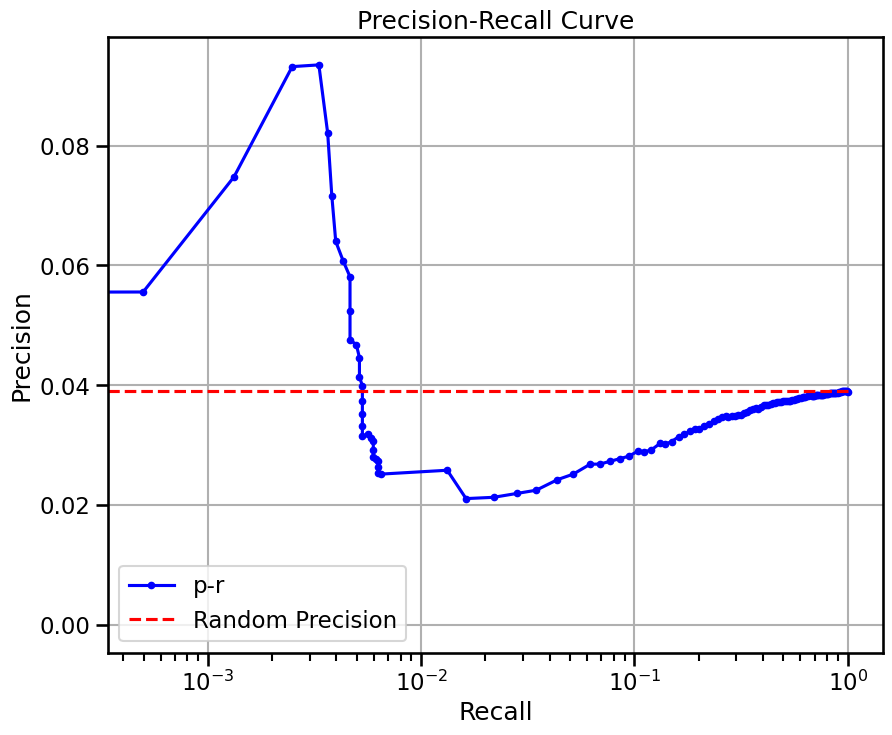

In [14]:
grn.varp['GRN'] = grn.varp['classified']
metrics['scprint_omni_han_full'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

base enrichment


Top central genes: []


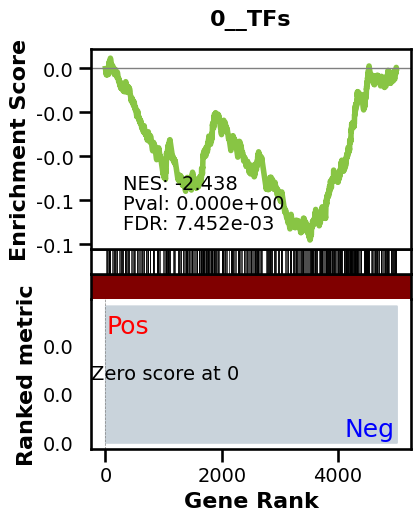

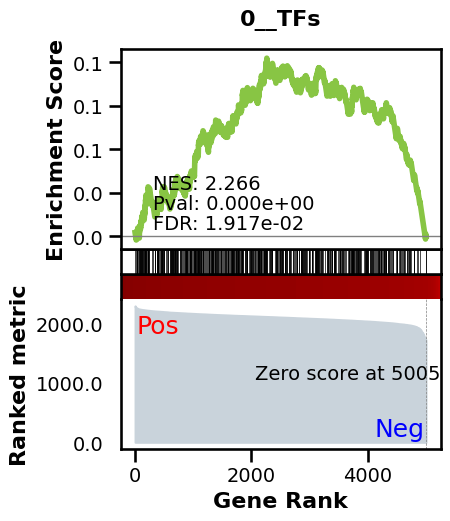

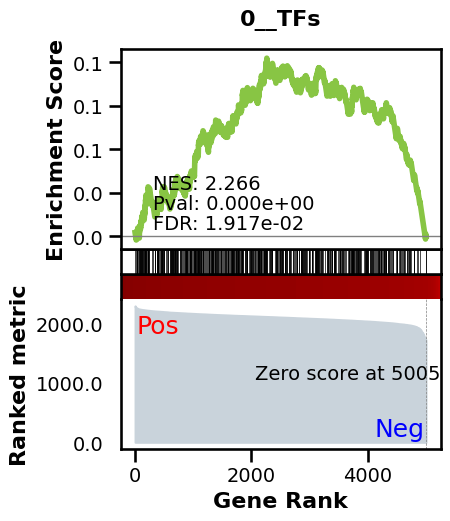

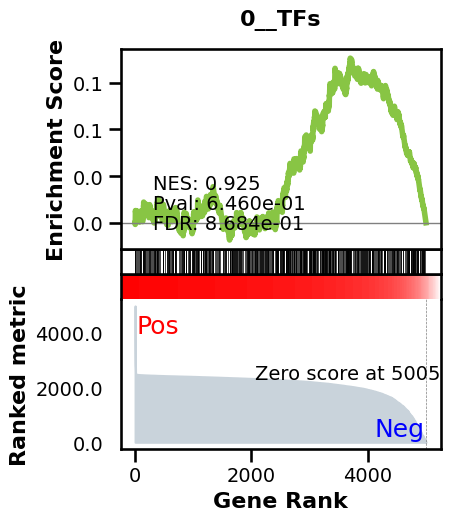

_________________________________________
TF specific enrichment


found some significant results for  3.6363636363636362 % TFs

_________________________________________
loading GT,  omnipath


intersection of 3767 genes
intersection pct: 0.7524970035956852
precision:  0.0016151890916386552 
recall:  1.0 
random precision: 0.001615617978811156



  0%|          | 0/128 [00:00<?, ?it/s]


  4%|▍         | 5/128 [00:00<00:03, 40.10it/s]


  8%|▊         | 10/128 [00:00<00:02, 40.22it/s]


 12%|█▏        | 15/128 [00:00<00:02, 40.08it/s]


 16%|█▌        | 20/128 [00:00<00:02, 40.05it/s]


 20%|█▉        | 25/128 [00:00<00:02, 39.69it/s]


 23%|██▎       | 29/128 [00:00<00:02, 39.33it/s]


 26%|██▌       | 33/128 [00:00<00:02, 39.20it/s]


 29%|██▉       | 37/128 [00:00<00:02, 39.16it/s]


 33%|███▎      | 42/128 [00:01<00:02, 39.61it/s]


 37%|███▋      | 47/128 [00:01<00:02, 39.84it/s]


 41%|████      | 52/128 [00:01<00:01, 40.05it/s]


 45%|████▍     | 57/128 [00:01<00:01, 40.15it/s]


 48%|████▊     | 62/128 [00:01<00:01, 40.23it/s]


 52%|█████▏    | 67/128 [00:01<00:01, 40.28it/s]


 56%|█████▋    | 72/128 [00:01<00:01, 40.29it/s]


 60%|██████    | 77/128 [00:01<00:01, 40.30it/s]


 64%|██████▍   | 82/128 [00:02<00:01, 40.36it/s]


 68%|██████▊   | 87/128 [00:02<00:01, 40.13it/s]


 72%|███████▏  | 92/128 [00:02<00:00, 40.04it/s]


 76%|███████▌  | 97/128 [00:02<00:00, 40.22it/s]


 80%|███████▉  | 102/128 [00:02<00:00, 39.84it/s]


 83%|████████▎ | 106/128 [00:02<00:00, 39.63it/s]


 86%|████████▌ | 110/128 [00:02<00:00, 39.47it/s]


 89%|████████▉ | 114/128 [00:02<00:00, 39.34it/s]


 92%|█████████▏| 118/128 [00:02<00:00, 39.35it/s]


 96%|█████████▌| 123/128 [00:03<00:00, 39.70it/s]

/pasteur/appa/homes/jkalfon/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()

100%|██████████| 128/128 [00:03<00:00, 39.85it/s]


100%|██████████| 128/128 [00:03<00:00, 39.86it/s]

Area Under Precision-Recall Curve (AUPRC):  0.0016597335453934078


EPR: 5.116867859465253


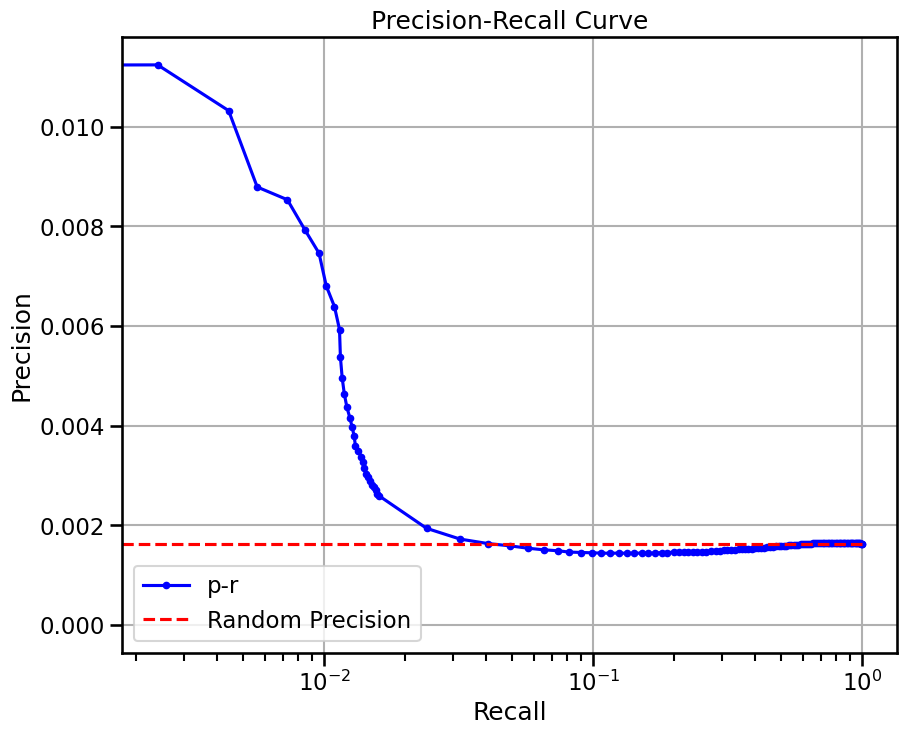

In [15]:
metrics['scprint_omni_han_base'] = BenGRN(grn, do_auc=True, doplot=True).scprint_benchmark()

precision:  0.264192 
recall:  1.0 
random precision: 0.26424484896979394



  0%|          | 0/128 [00:00<?, ?it/s]


 37%|███▋      | 47/128 [00:00<00:00, 460.17it/s]


 73%|███████▎  | 94/128 [00:00<00:00, 461.20it/s]

/pasteur/appa/homes/jkalfon/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()

100%|██████████| 128/128 [00:00<00:00, 460.89it/s]

Area Under Precision-Recall Curve (AUPRC):  0.24434708945360423
EPR: 0.7665527604309154


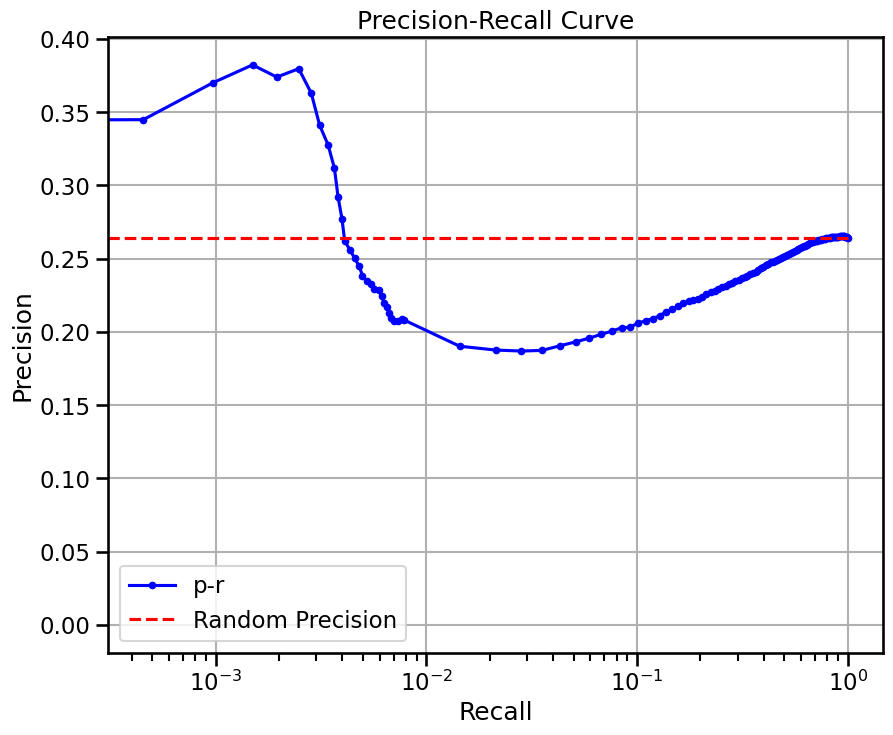

In [16]:
preadata = get_sroy_gt(get="han", species="human", gt="chip")
metrics['scprint_omni_han_chip'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

precision:  0.08270819672131148 
recall:  1.0 
random precision: 0.0827247416696454



  0%|          | 0/128 [00:00<?, ?it/s]


 30%|███       | 39/128 [00:00<00:00, 386.18it/s]


 61%|██████    | 78/128 [00:00<00:00, 386.18it/s]


 91%|█████████▏| 117/128 [00:00<00:00, 386.41it/s]

/pasteur/appa/homes/jkalfon/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()

100%|██████████| 128/128 [00:00<00:00, 385.62it/s]

Area Under Precision-Recall Curve (AUPRC):  0.07761441980402883
EPR: 0.7330050915595431


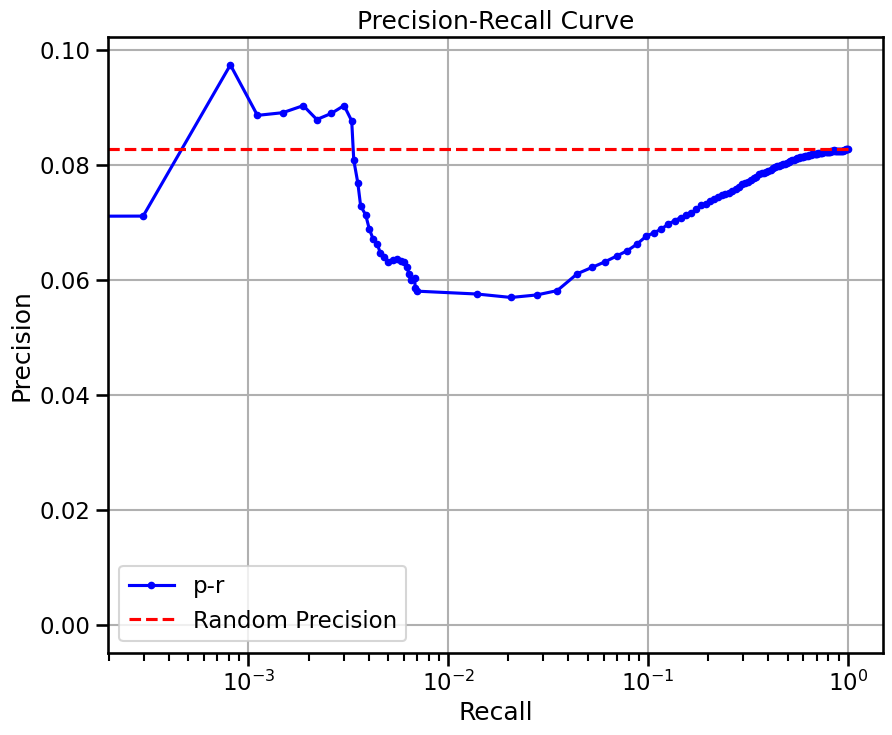

In [17]:
preadata = get_sroy_gt(get="han", species="human", gt="ko")
metrics['scprint_omni_han_ko'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

pred shape (122, 5000, 128)
true elem 50452 ...
doing classification....


metrics {'used_heads': 47, 'precision': 0.0829833283726331, 'random_precision': 0.08208196721311475, 'recall': 0.9020571200319553, 'predicted_true': 272139.0, 'number_of_true': 25035.0, 'epr': 1.236234020897317}


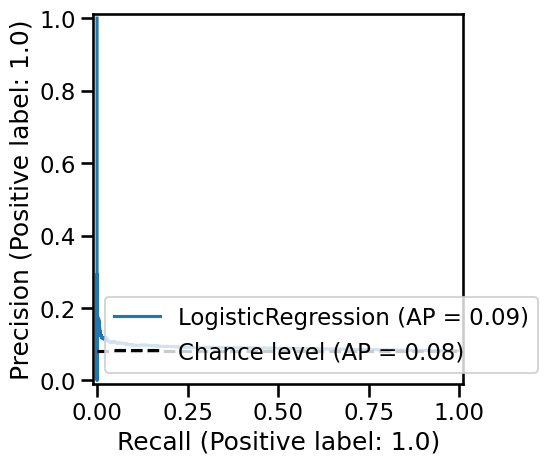

precision:  0.08270819672131148 
recall:  1.0 
random precision: 0.0827247416696454



  0%|          | 0/128 [00:00<?, ?it/s]


 30%|███       | 39/128 [00:00<00:00, 385.83it/s]


 61%|██████    | 78/128 [00:00<00:00, 385.72it/s]


 91%|█████████▏| 117/128 [00:00<00:00, 386.20it/s]

/pasteur/appa/homes/jkalfon/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()

100%|██████████| 128/128 [00:00<00:00, 385.10it/s]

Area Under Precision-Recall Curve (AUPRC):  0.09282995364983734
EPR: 1.2882910380173476


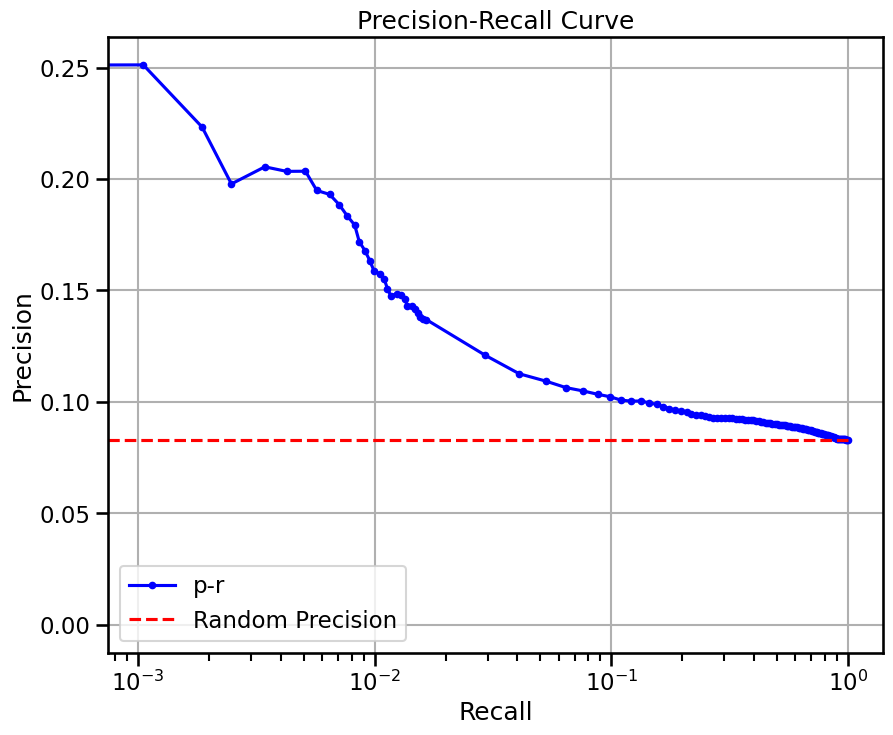

In [18]:
grn.varp['GRN'] =grn.varp['all']
weight = int((preadata.grn.sum(1)>0).sum()* (preadata.grn.sum(0)>0).sum()/ preadata.grn.sum().sum())
grn, m, clf_self = train_classifier(
    grn, other=preadata, C=0.1, train_size=0.5, class_weight={1: weight, 0: 1}, shuffle=True, max_iter=500,)
grn.varp['GRN'] = grn.varp['classified']
metrics['scprint_self_han_full'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

In [19]:
joblib.dump(clf_self, 'clf_self_model.pkl')

['clf_self_model.pkl']

base enrichment


Top central genes: []


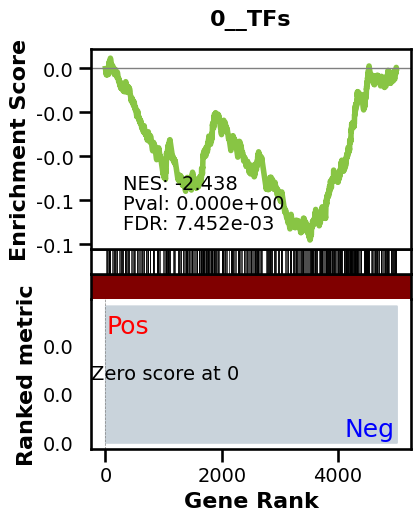

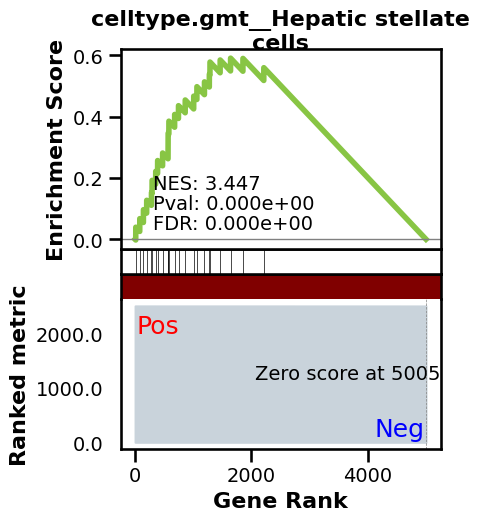

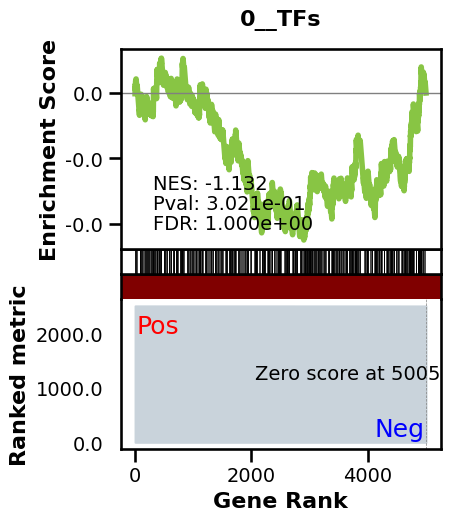

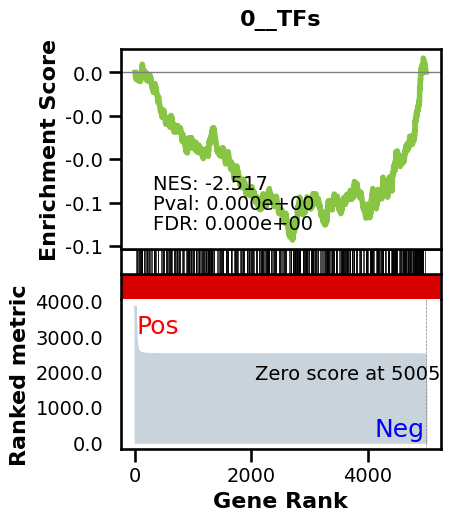

_________________________________________
TF specific enrichment


found some significant results for  30.90909090909091 % TFs

_________________________________________
loading GT,  omnipath


intersection of 3767 genes
intersection pct: 0.7524970035956852
precision:  0.0016151890916386552 
recall:  1.0 
random precision: 0.001615617978811156



  0%|          | 0/128 [00:00<?, ?it/s]


  3%|▎         | 4/128 [00:00<00:03, 39.62it/s]


  6%|▋         | 8/128 [00:00<00:03, 39.51it/s]


  9%|▉         | 12/128 [00:00<00:02, 39.42it/s]


 12%|█▎        | 16/128 [00:00<00:02, 39.40it/s]


 16%|█▌        | 20/128 [00:00<00:02, 39.11it/s]


 19%|█▉        | 24/128 [00:00<00:02, 39.20it/s]


 22%|██▏       | 28/128 [00:00<00:02, 39.06it/s]


 25%|██▌       | 32/128 [00:00<00:02, 38.81it/s]


 28%|██▊       | 36/128 [00:00<00:02, 38.63it/s]


 31%|███▏      | 40/128 [00:01<00:02, 38.61it/s]


 34%|███▍      | 44/128 [00:01<00:02, 38.67it/s]


 38%|███▊      | 48/128 [00:01<00:02, 38.74it/s]


 41%|████      | 52/128 [00:01<00:01, 38.90it/s]


 44%|████▍     | 56/128 [00:01<00:01, 39.02it/s]


 47%|████▋     | 60/128 [00:01<00:01, 39.17it/s]


 50%|█████     | 64/128 [00:01<00:01, 39.24it/s]


 53%|█████▎    | 68/128 [00:01<00:01, 39.18it/s]


 56%|█████▋    | 72/128 [00:01<00:01, 39.17it/s]


 59%|█████▉    | 76/128 [00:01<00:01, 39.04it/s]


 62%|██████▎   | 80/128 [00:02<00:01, 39.17it/s]


 66%|██████▌   | 84/128 [00:02<00:01, 39.20it/s]


 69%|██████▉   | 88/128 [00:02<00:01, 39.42it/s]


 72%|███████▏  | 92/128 [00:02<00:00, 39.52it/s]


 75%|███████▌  | 96/128 [00:02<00:00, 39.63it/s]


 78%|███████▊  | 100/128 [00:02<00:00, 39.57it/s]


 81%|████████▏ | 104/128 [00:02<00:00, 39.51it/s]


 84%|████████▍ | 108/128 [00:02<00:00, 39.14it/s]


 88%|████████▊ | 112/128 [00:02<00:00, 38.90it/s]


 91%|█████████ | 116/128 [00:02<00:00, 38.79it/s]


 94%|█████████▍| 120/128 [00:03<00:00, 38.88it/s]


 97%|█████████▋| 124/128 [00:03<00:00, 38.79it/s]

/pasteur/appa/homes/jkalfon/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()



100%|██████████| 128/128 [00:03<00:00, 39.08it/s]


100%|██████████| 128/128 [00:03<00:00, 39.10it/s]

Area Under Precision-Recall Curve (AUPRC):  0.0017097454167158384
EPR: 1.053382643934359


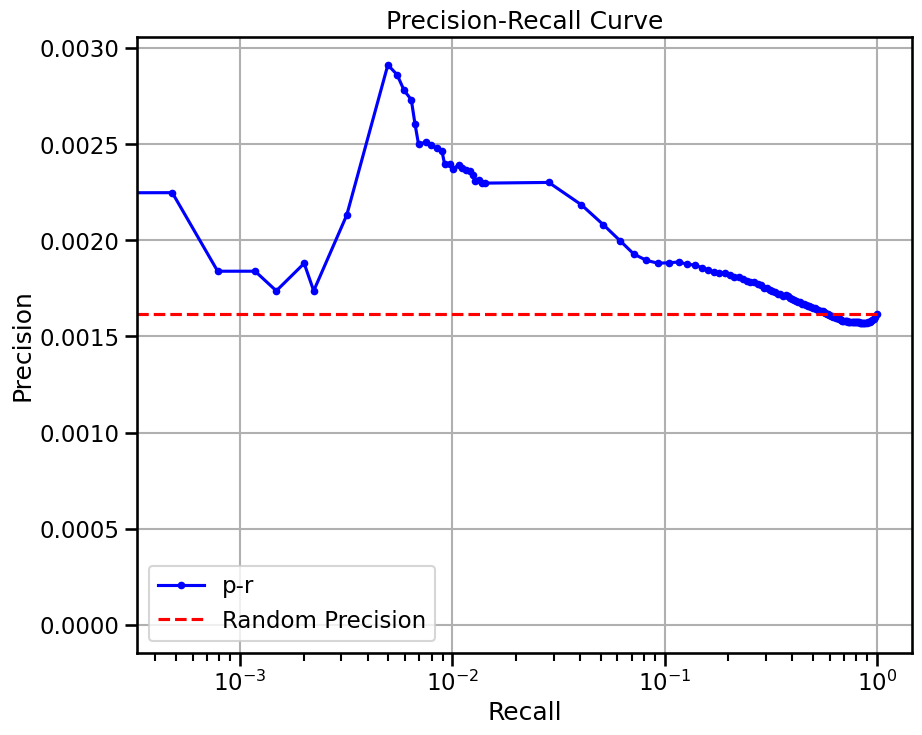

In [20]:
grn.varp['GRN'] = grn.varp['classified']
metrics['scprint_self_han_base'] = BenGRN(grn, do_auc=True, doplot=True).scprint_benchmark()

precision:  0.264192 
recall:  1.0 
random precision: 0.26424484896979394



  0%|          | 0/128 [00:00<?, ?it/s]


 37%|███▋      | 47/128 [00:00<00:00, 463.46it/s]


 73%|███████▎  | 94/128 [00:00<00:00, 463.46it/s]

/pasteur/appa/homes/jkalfon/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()

100%|██████████| 128/128 [00:00<00:00, 462.80it/s]

Area Under Precision-Recall Curve (AUPRC):  0.25929989630330463
EPR: 0.9644244530975711


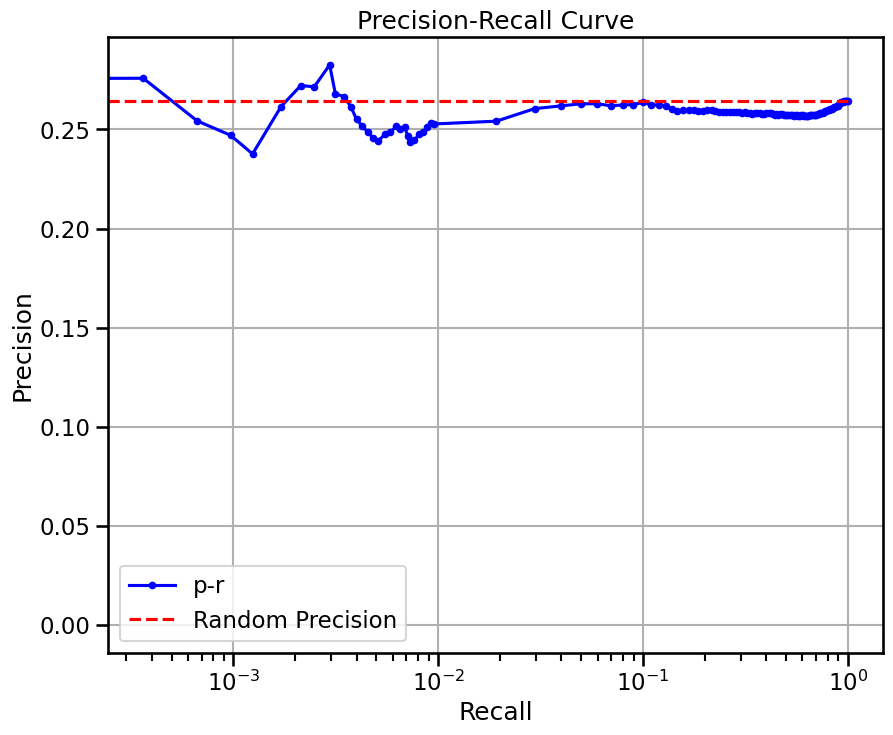

In [21]:
grn.varp['GRN'] = grn.varp['classified']
preadata = get_sroy_gt(get="han", species="human", gt="chip")
metrics['scprint_self_han_chip'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

precision:  0.08270819672131148 
recall:  1.0 
random precision: 0.0827247416696454



  0%|          | 0/128 [00:00<?, ?it/s]


 30%|██▉       | 38/128 [00:00<00:00, 379.37it/s]


 60%|██████    | 77/128 [00:00<00:00, 383.34it/s]


 91%|█████████ | 116/128 [00:00<00:00, 385.25it/s]

/pasteur/appa/homes/jkalfon/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()

100%|██████████| 128/128 [00:00<00:00, 383.96it/s]

Area Under Precision-Recall Curve (AUPRC):  0.09282995364983734
EPR: 1.2882910380173476


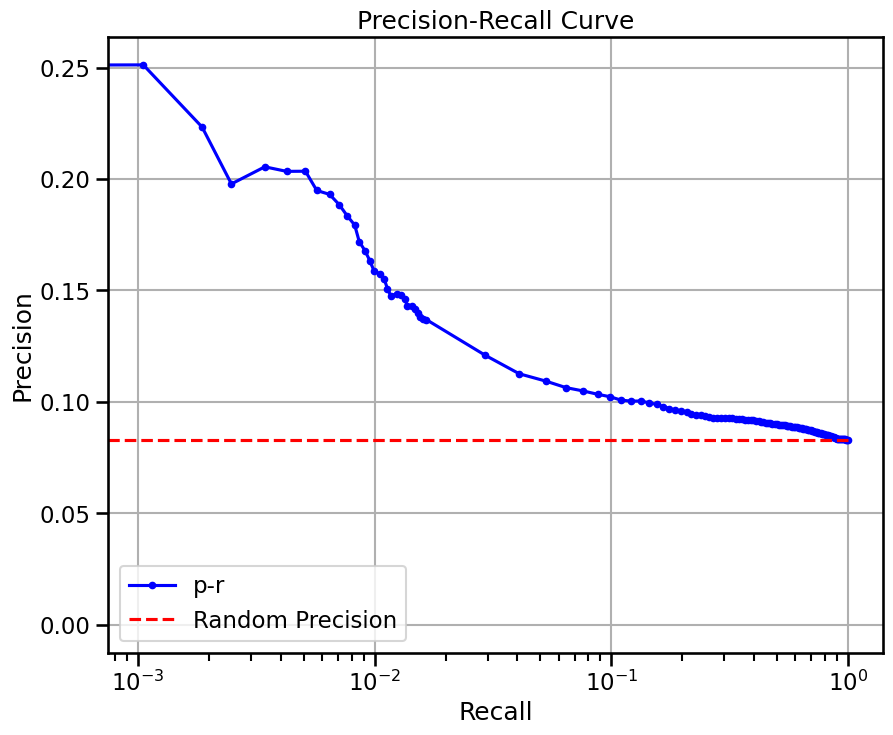

In [22]:
preadata = get_sroy_gt(get="han", species="human", gt="ko")
metrics['scprint_self_han_ko'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

In [23]:
del grn

# mine / human

In [24]:
preadata = get_sroy_gt(get="mine", species="human", gt="full")
adata = preprocessor(preadata.copy())
adata.var["isTF"] = False
adata.var.loc[adata.var.symbol.isin(grnutils.TF), "isTF"] = True
preadata, (preadata.grn.sum(1) != 0).sum()

Dropping layers:  KeysView(Layers with keys: )
checking raw counts
Data is not raw counts, please check layers, find raw data, or bypass with force_preprocess
removed 0 non primary cells, 115 renamining


filtered out 0 cells, 115 renamining
Removed 0 genes.


startin QC
Seeing 105 outliers (91.30% of total dataset):


done


(GRnnData object with n_obs × n_vars = 115 × 28466
     obs: 'organism_ontology_term_id'
     var: 'ensembl_id'
     varp: 'GRN'
     with a grn of 11563 elements,
 35)

In [25]:
grn_inferer = GRNfer(model, adata,
                     how="most var within",
                     genes=adata.var[adata.var.symbol.isin(preadata.var[preadata.grn.sum(1) != 0].index.tolist())].index.tolist(),
                     preprocess="softmax",
                     head_agg='none',
                     filtration="none",
                     forward_mode="none",
                     organisms=['NCBITaxon:9606','NCBITaxon:10090'],
                     apc=False,
                     symmetrize=False,
                     num_genes=MAXGENES,
                     max_cells=MAXCELLS,
                     doplot=False,
                     batch_size=32,
                     )
grn = grn_inferer(layer=list(range(model.nlayers))[:])

Using 16bit Automatic Mixed Precision (AMP)


GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


number of expressed genes in this cell type: 23510


/pasteur/appa/homes/jkalfon/scPRINT/scprint/tasks/grn.py:165: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  organisms=[subadata.obs['organism_ontology_term_id'][0]],


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


SLURM auto-requeueing enabled. Setting signal handlers.


Predicting: |          | 0/? [00:00<?, ?it/s]

In [26]:
grn.varp["all"] = grn.varp['GRN']
grn.var['ensembl_id'] = grn.var.index
grn.var['symbol'] = make_index_unique(grn.var['symbol'].astype(str))
grn.var.index = grn.var['symbol']

precision:  0.02702416768605151 
recall:  1.0 
random precision: 0.02703042328042328



  0%|          | 0/128 [00:00<?, ?it/s]

/pasteur/appa/homes/jkalfon/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()

100%|██████████| 128/128 [00:00<00:00, 2675.55it/s]

Area Under Precision-Recall Curve (AUPRC):  0.02754659466579145
EPR: 0.9668462286305901


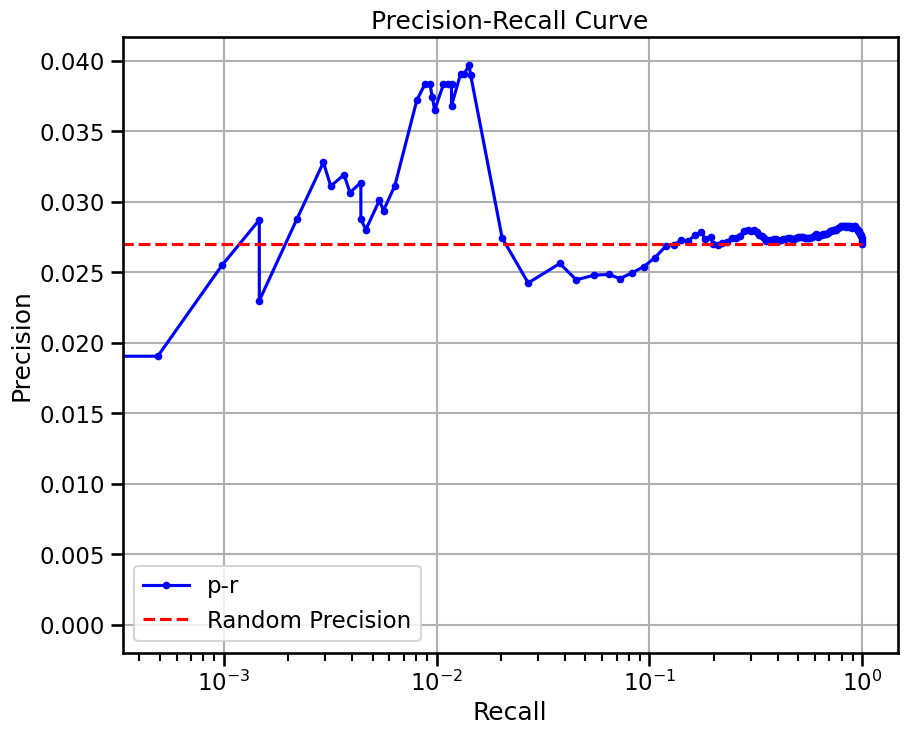

In [27]:
grn.varp['GRN'] = grn.varp['all'].mean(-1)
metrics['scprint_mean_mine_full'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

base enrichment


Top central genes: []


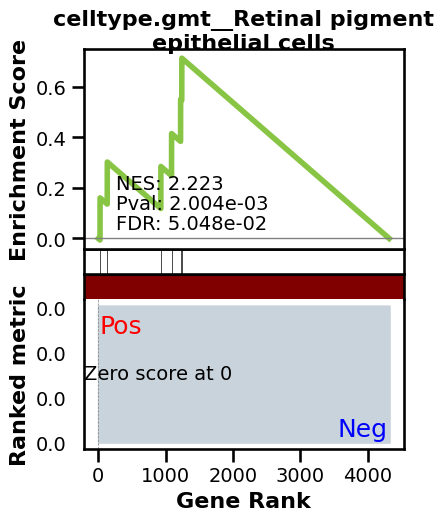

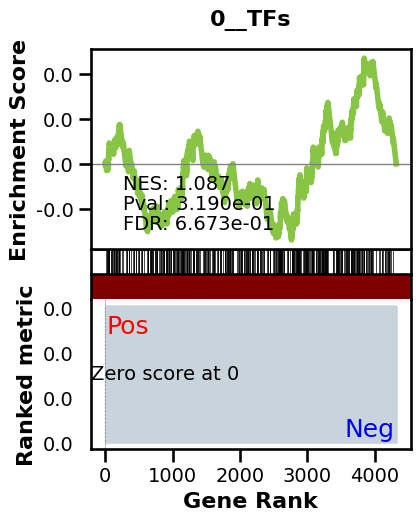

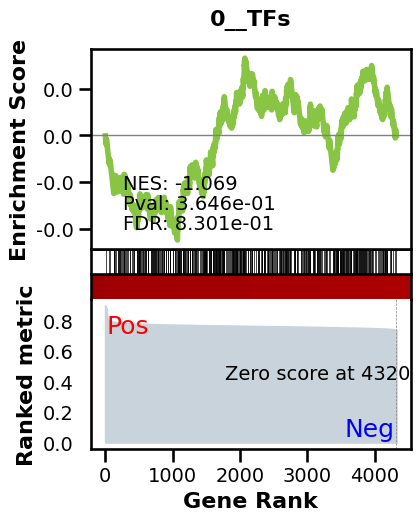

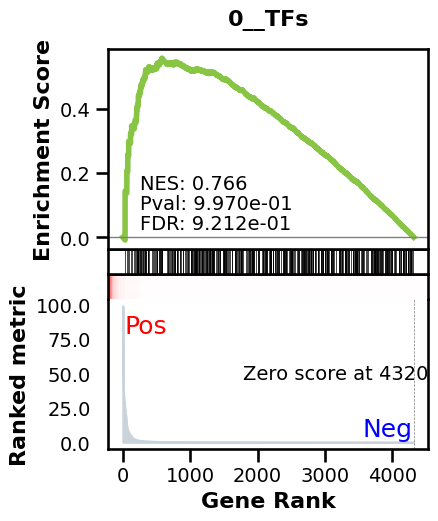

_________________________________________
TF specific enrichment


found some significant results for  31.11111111111111 % TFs

_________________________________________
loading GT,  omnipath


intersection of 2847 genes
intersection pct: 0.658875260356399
precision:  0.0015948609132494117 
recall:  1.0 
random precision: 0.0015954213000776791



  0%|          | 0/128 [00:00<?, ?it/s]


  7%|▋         | 9/128 [00:00<00:01, 86.65it/s]


 14%|█▍        | 18/128 [00:00<00:01, 86.62it/s]


 21%|██        | 27/128 [00:00<00:01, 86.65it/s]


 28%|██▊       | 36/128 [00:00<00:01, 86.64it/s]


 35%|███▌      | 45/128 [00:00<00:00, 86.61it/s]


 42%|████▏     | 54/128 [00:00<00:00, 86.60it/s]


 49%|████▉     | 63/128 [00:00<00:00, 86.45it/s]


 56%|█████▋    | 72/128 [00:00<00:00, 86.67it/s]


 63%|██████▎   | 81/128 [00:00<00:00, 86.57it/s]


 70%|███████   | 90/128 [00:01<00:00, 86.59it/s]


 77%|███████▋  | 99/128 [00:01<00:00, 86.50it/s]


 84%|████████▍ | 108/128 [00:01<00:00, 86.43it/s]


 91%|█████████▏| 117/128 [00:01<00:00, 86.66it/s]


 98%|█████████▊| 126/128 [00:01<00:00, 86.63it/s]

/pasteur/appa/homes/jkalfon/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()

100%|██████████| 128/128 [00:01<00:00, 86.50it/s]

Area Under Precision-Recall Curve (AUPRC):  0.0018452386275532849
EPR: 1.7985903578708906


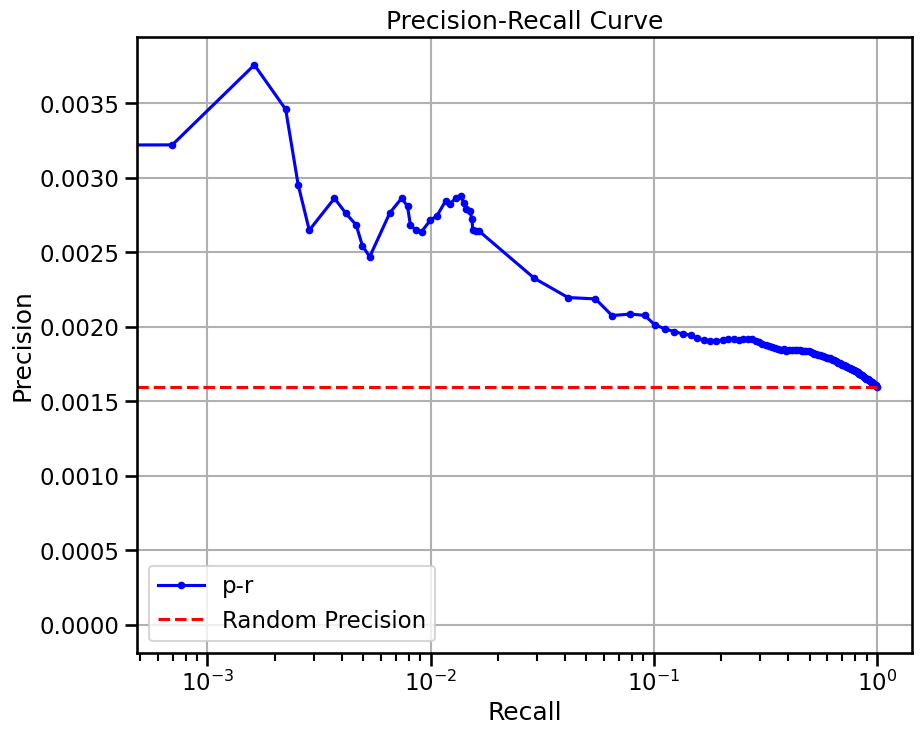

In [28]:
metrics['scprint_mean_mine_base'] = BenGRN(grn, do_auc=True, doplot=True).scprint_benchmark()

precision:  0.027024882464574063 
recall:  1.0 
random precision: 0.02703042328042328



  0%|          | 0/128 [00:00<?, ?it/s]

/pasteur/appa/homes/jkalfon/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()

100%|██████████| 128/128 [00:00<00:00, 2615.37it/s]

Area Under Precision-Recall Curve (AUPRC):  0.02639009007581879
EPR: 0.4569715116645093


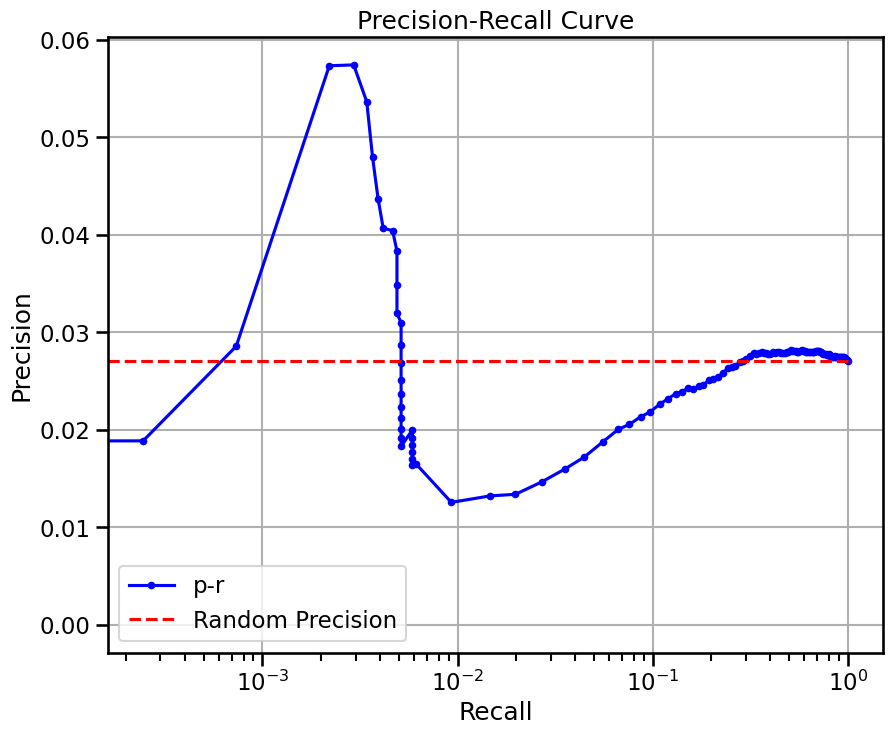

In [29]:
grn.varp["GRN"] = clf_omni.predict_proba(
    grn.varp['all'].reshape(-1, grn.varp['all'].shape[-1])
).reshape(len(grn.var), len(grn.var), 2)[:, :, 1]
metrics['scprint_omni_mine_full'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

base enrichment


Top central genes: []


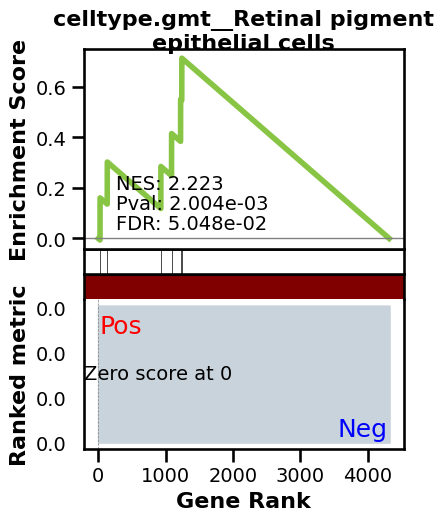

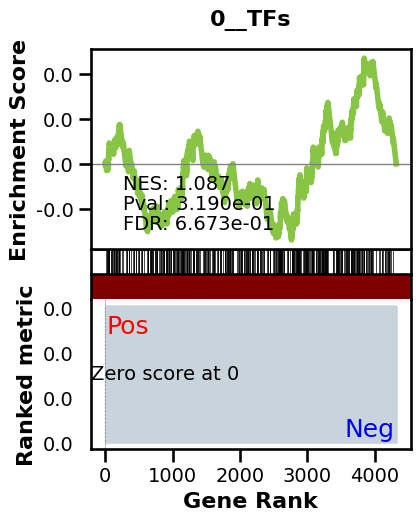

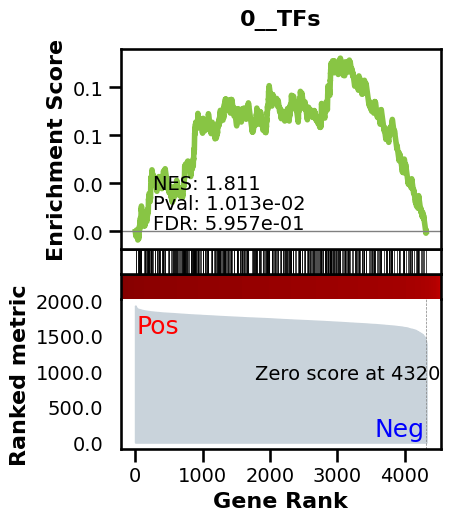

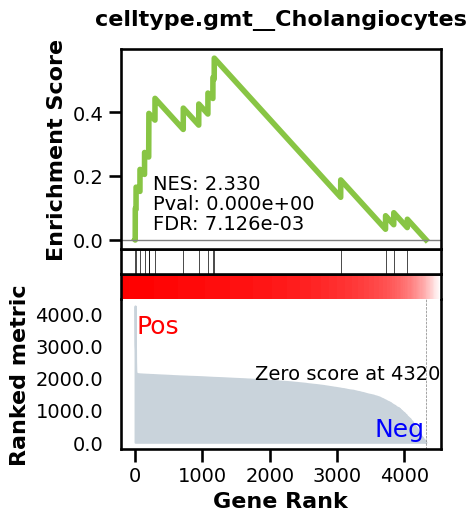

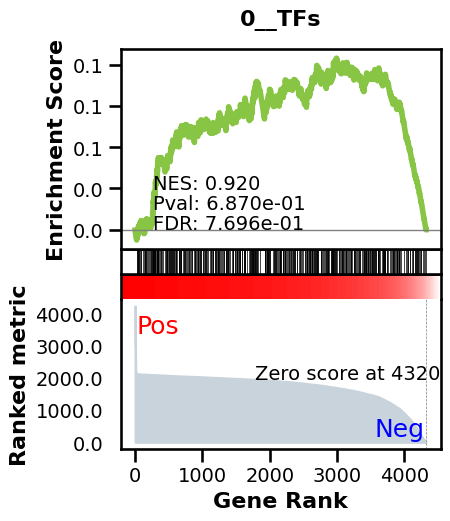

_________________________________________
TF specific enrichment


found some significant results for  6.666666666666667 % TFs

_________________________________________
loading GT,  omnipath


intersection of 2847 genes
intersection pct: 0.658875260356399
precision:  0.001594947691341903 
recall:  1.0 
random precision: 0.0015954213000776791



  0%|          | 0/128 [00:00<?, ?it/s]


  6%|▋         | 8/128 [00:00<00:01, 72.89it/s]


 12%|█▎        | 16/128 [00:00<00:01, 73.93it/s]


 19%|█▉        | 24/128 [00:00<00:01, 73.46it/s]


 25%|██▌       | 32/128 [00:00<00:01, 73.19it/s]


 31%|███▏      | 40/128 [00:00<00:01, 73.09it/s]


 38%|███▊      | 48/128 [00:00<00:01, 73.65it/s]


 44%|████▍     | 56/128 [00:00<00:00, 73.40it/s]


 50%|█████     | 64/128 [00:00<00:00, 73.02it/s]


 56%|█████▋    | 72/128 [00:00<00:00, 72.99it/s]


 62%|██████▎   | 80/128 [00:01<00:00, 72.96it/s]


 69%|██████▉   | 88/128 [00:01<00:00, 72.95it/s]


 75%|███████▌  | 96/128 [00:01<00:00, 72.94it/s]


 81%|████████▏ | 104/128 [00:01<00:00, 72.93it/s]


 88%|████████▊ | 112/128 [00:01<00:00, 72.95it/s]


 94%|█████████▍| 120/128 [00:01<00:00, 72.95it/s]

/pasteur/appa/homes/jkalfon/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()

100%|██████████| 128/128 [00:01<00:00, 72.91it/s]


100%|██████████| 128/128 [00:01<00:00, 73.05it/s]

Area Under Precision-Recall Curve (AUPRC):  0.001543630026350229
EPR: 3.469643235210066


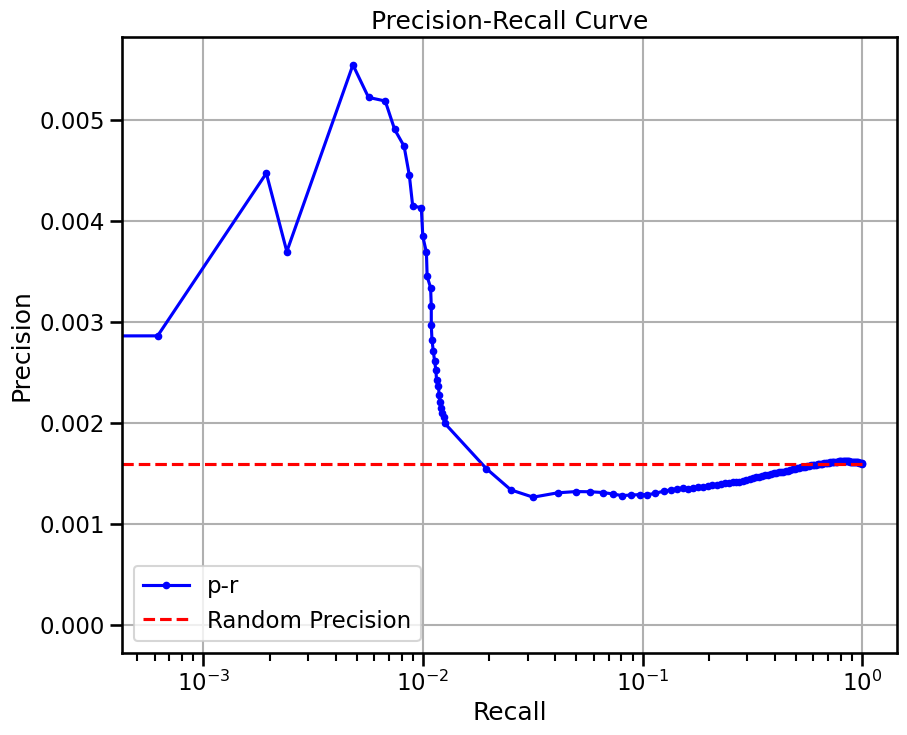

In [30]:
metrics['scprint_omni_mine_base'] = BenGRN(grn, do_auc=True, doplot=True).scprint_benchmark()

precision:  0.02702416768605151 
recall:  1.0 
random precision: 0.02703042328042328



  0%|          | 0/128 [00:00<?, ?it/s]

/pasteur/appa/homes/jkalfon/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()

100%|██████████| 128/128 [00:00<00:00, 2612.00it/s]

Area Under Precision-Recall Curve (AUPRC):  0.027793470427075844
EPR: 1.4454628528843487


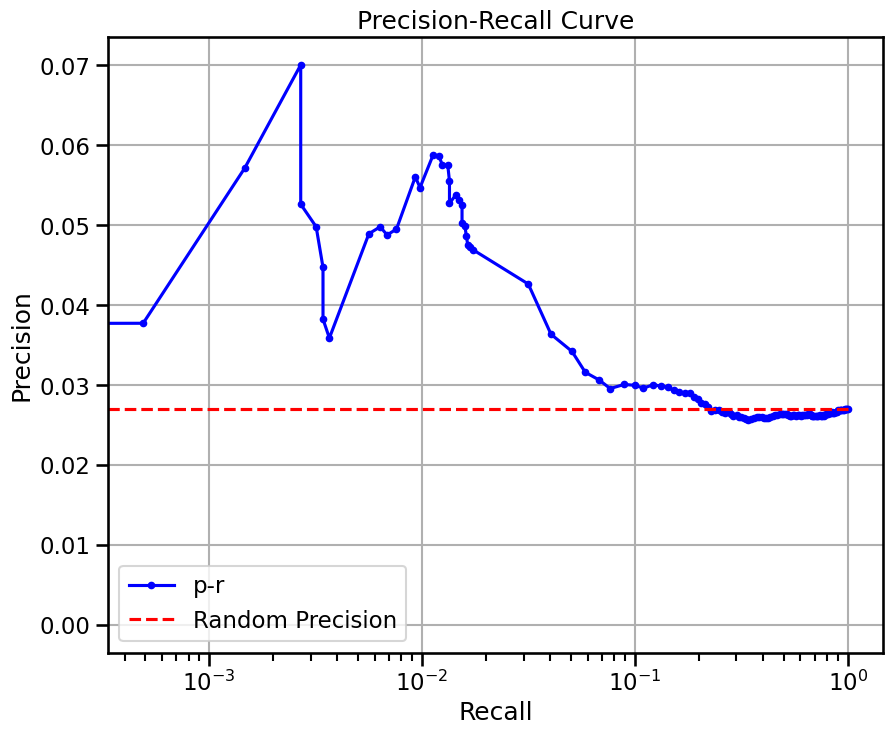

In [31]:
grn.varp["GRN"] = clf_self.predict_proba(
    grn.varp['all'].reshape(-1, grn.varp['all'].shape[-1])
).reshape(len(grn.var), len(grn.var), 2)[:, :, 1]
metrics['scprint_self_mine_full'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

base enrichment


Top central genes: []


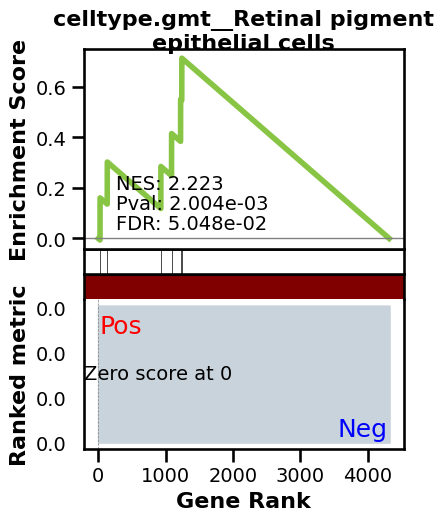

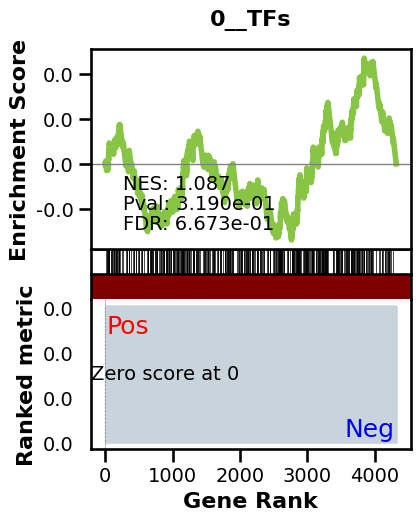

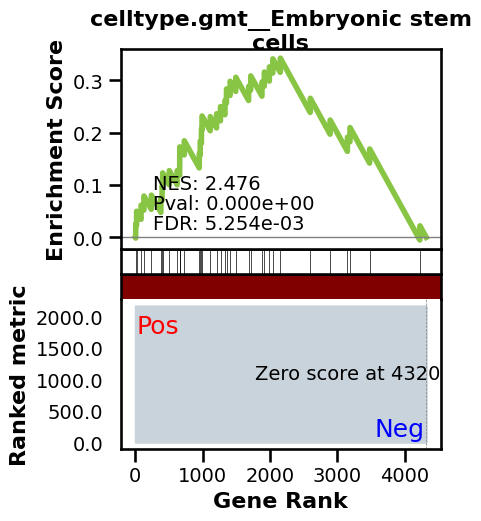

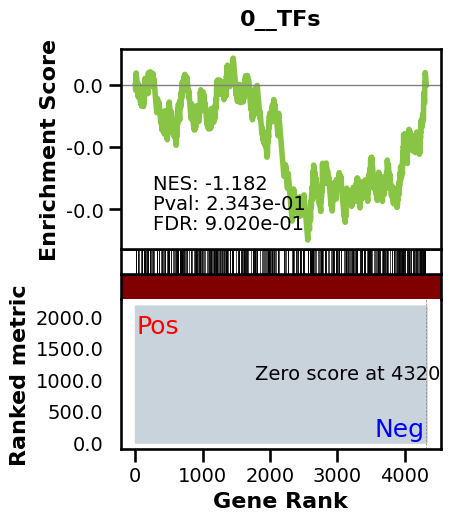

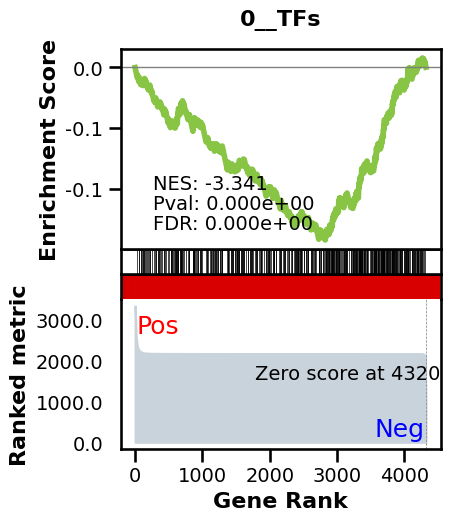

_________________________________________
TF specific enrichment


found some significant results for  13.333333333333334 % TFs

_________________________________________
loading GT,  omnipath


intersection of 2847 genes
intersection pct: 0.658875260356399
precision:  0.0015948609132494117 
recall:  1.0 
random precision: 0.0015954213000776791



  0%|          | 0/128 [00:00<?, ?it/s]


  6%|▋         | 8/128 [00:00<00:01, 74.33it/s]


 12%|█▎        | 16/128 [00:00<00:01, 74.32it/s]


 19%|█▉        | 24/128 [00:00<00:01, 74.29it/s]


 25%|██▌       | 32/128 [00:00<00:01, 74.32it/s]


 31%|███▏      | 40/128 [00:00<00:01, 74.63it/s]


 38%|███▊      | 48/128 [00:00<00:01, 74.86it/s]


 44%|████▍     | 56/128 [00:00<00:00, 74.69it/s]


 50%|█████     | 64/128 [00:00<00:00, 74.53it/s]


 56%|█████▋    | 72/128 [00:00<00:00, 74.76it/s]


 62%|██████▎   | 80/128 [00:01<00:00, 74.91it/s]


 69%|██████▉   | 88/128 [00:01<00:00, 74.70it/s]


 75%|███████▌  | 96/128 [00:01<00:00, 74.55it/s]


 81%|████████▏ | 104/128 [00:01<00:00, 74.44it/s]


 88%|████████▊ | 112/128 [00:01<00:00, 73.92it/s]


 94%|█████████▍| 120/128 [00:01<00:00, 74.58it/s]

/pasteur/appa/homes/jkalfon/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()

100%|██████████| 128/128 [00:01<00:00, 74.90it/s]


100%|██████████| 128/128 [00:01<00:00, 74.59it/s]

Area Under Precision-Recall Curve (AUPRC):  0.0016708912830078779
EPR: 1.9453281310901598


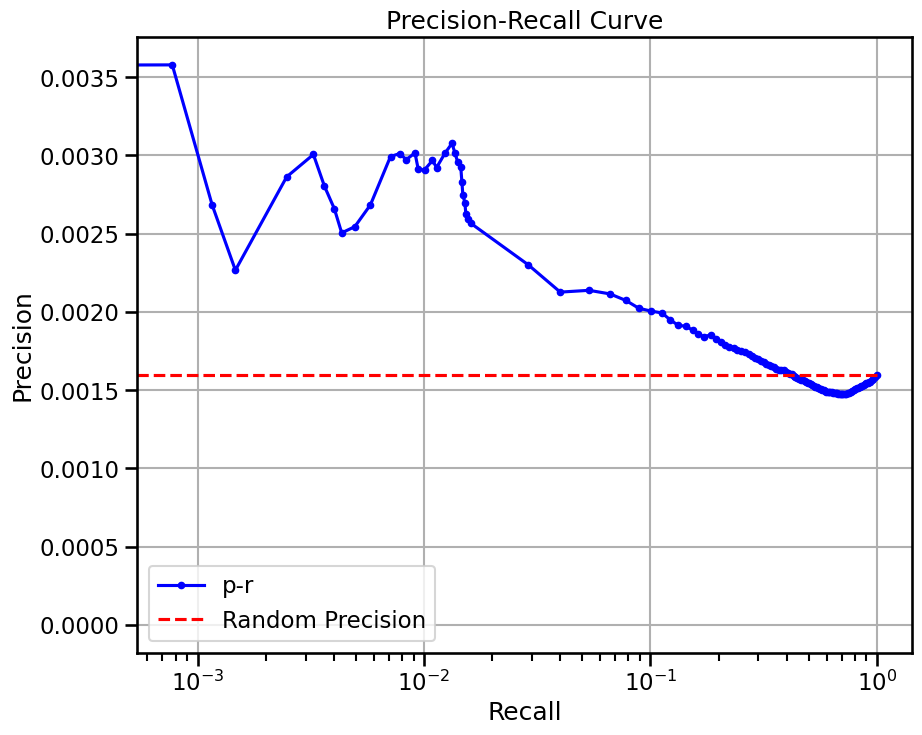

In [32]:
metrics['scprint_self_mine_base'] = BenGRN(grn, do_auc=True, doplot=True).scprint_benchmark()

In [33]:
del grn

In [34]:
metrics

{'scprint_mean_han_full': {'precision': 0.038948387096774194,
  'recall': 1.0,
  'rand_precision': 0.03895617833244068,
  'auprc': 0.040911006732137586,
  'epr': 1.1764152910621384},
 'scprint_mean_han_base': {'TF_enr': True,
  'enriched_terms_Targets': ['celltype.gmt__Hepatic stellate cells',
   'celltype.gmt__Stromal cells',
   'celltype.gmt__Fibroblasts',
   'celltype.gmt__Mesenchymal stem cells',
   'celltype.gmt__Pancreatic stellate cells',
   'celltype.gmt__Podocytes',
   'celltype.gmt__Cholangiocytes',
   'celltype.gmt__Endothelial cells',
   'celltype.gmt__Acinar cells',
   'celltype.gmt__Myocytes',
   'celltype.gmt__Endothelial',
   'celltype.gmt__Perivascular cells',
   'celltype.gmt__Principal cells (Collecting duct system)',
   'celltype.gmt__Odontoblasts',
   'celltype.gmt__Enteroendocrine cells',
   'celltype.gmt__Pulmonary alveolar type I cells',
   'celltype.gmt__Smooth muscle cells',
   'celltype.gmt__Leydig cells',
   'celltype.gmt__Adipose progenitor cells',
   'cell

## tran / mouse

In [35]:
preadata = get_sroy_gt(get="tran", species="mouse", gt="full")
adata = preprocessor(preadata.copy())
adata.var["isTF"] = False
adata.var.loc[adata.var.symbol.isin(grnutils.TF), "isTF"] = True
preadata, (preadata.grn.sum(1) != 0).sum()

Dropping layers:  KeysView(Layers with keys: )
checking raw counts
removed 0 non primary cells, 2369 renamining


filtered out 0 cells, 2369 renamining
Removed 0 genes.


startin QC
Seeing 91 outliers (3.84% of total dataset):


done


(GRnnData object with n_obs × n_vars = 2369 × 6618
     obs: 'organism_ontology_term_id'
     varp: 'GRN'
     with a grn of 7162 elements,
 31)

In [36]:
grn_inferer = GRNfer(model, adata,
                     how="most var within",
                     genes=adata.var[adata.var.symbol.isin(preadata.var[preadata.grn.sum(1) != 0].index.tolist())].index.tolist(),
                     preprocess="softmax",
                     head_agg='none',
                     filtration="none",
                     forward_mode="none",
                     organisms=['NCBITaxon:9606','NCBITaxon:10090'],
                     apc=False,
                     symmetrize=False,
                     num_genes=MAXGENES,
                     max_cells=MAXCELLS,
                     doplot=False,
                     batch_size=32,
                     )
grn = grn_inferer(layer=list(range(model.nlayers))[:])

Using 16bit Automatic Mixed Precision (AMP)


GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


number of expressed genes in this cell type: 6435


/pasteur/appa/homes/jkalfon/scPRINT/scprint/tasks/grn.py:165: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  organisms=[subadata.obs['organism_ontology_term_id'][0]],


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


SLURM auto-requeueing enabled. Setting signal handlers.


Predicting: |          | 0/? [00:00<?, ?it/s]

In [37]:
grn.varp["all"] = grn.varp['GRN']
grn.var['ensembl_id'] = grn.var.index
grn.var['symbol'] = make_index_unique(grn.var['symbol'].astype(str))
grn.var.index = grn.var['symbol']

precision:  0.04014336917562724 
recall:  1.0 
random precision: 0.04015140749544615



  0%|          | 0/128 [00:00<?, ?it/s]

/pasteur/appa/homes/jkalfon/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()

100%|██████████| 128/128 [00:00<00:00, 2182.75it/s]

Area Under Precision-Recall Curve (AUPRC):  0.044191266148795164
EPR: 1.3318697865032914


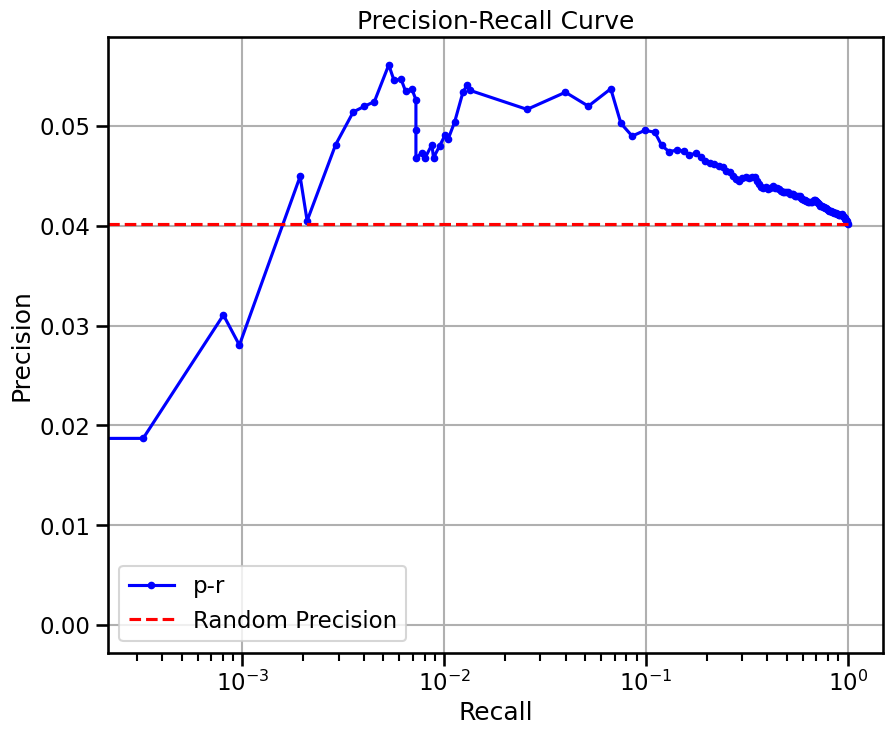

In [38]:
grn.varp['GRN'] = grn.varp['all'].mean(-1)
metrics['scprint_mean_tran_full'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

precision:  0.20101723344966588 
recall:  1.0 
random precision: 0.20105748519845437



  0%|          | 0/128 [00:00<?, ?it/s]


 55%|█████▌    | 71/128 [00:00<00:00, 704.27it/s]

/pasteur/appa/homes/jkalfon/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()

100%|██████████| 128/128 [00:00<00:00, 703.11it/s]

Area Under Precision-Recall Curve (AUPRC):  0.21281303813687832
EPR: 1.0914172417329715


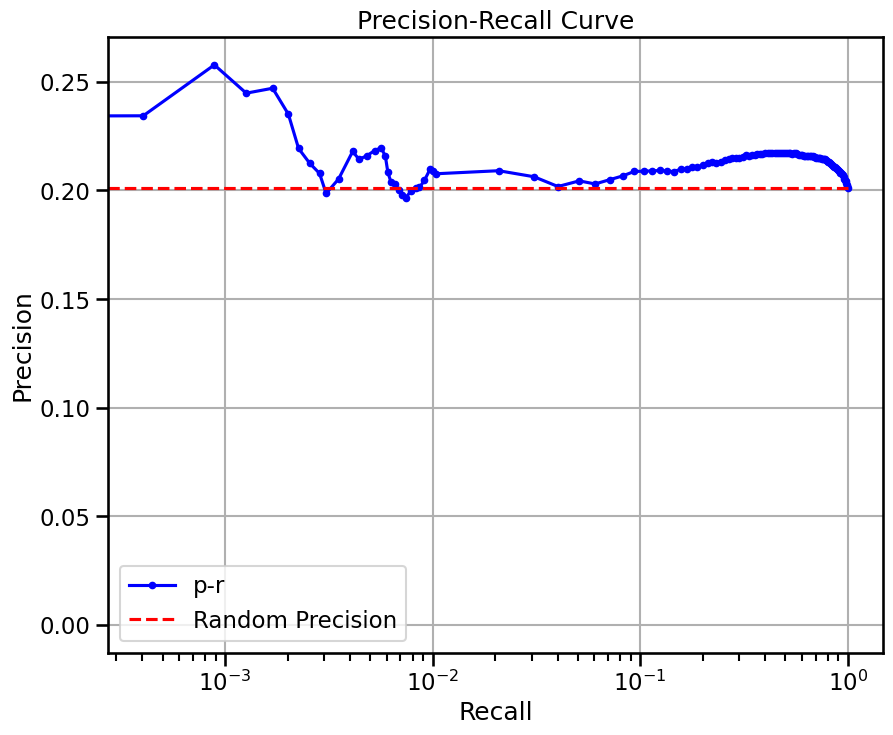

In [39]:
preadata = get_sroy_gt(get="tran", species="mouse", gt="chip")
metrics['scprint_mean_tran_chip'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

precision:  0.0857875419278928 
recall:  1.0 
random precision: 0.08580472005002494



  0%|          | 0/128 [00:00<?, ?it/s]


 34%|███▎      | 43/128 [00:00<00:00, 422.40it/s]


 67%|██████▋   | 86/128 [00:00<00:00, 423.25it/s]

/pasteur/appa/homes/jkalfon/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()



100%|██████████| 128/128 [00:00<00:00, 423.23it/s]

Area Under Precision-Recall Curve (AUPRC):  0.08698746280819455
EPR: 1.0720072954391355


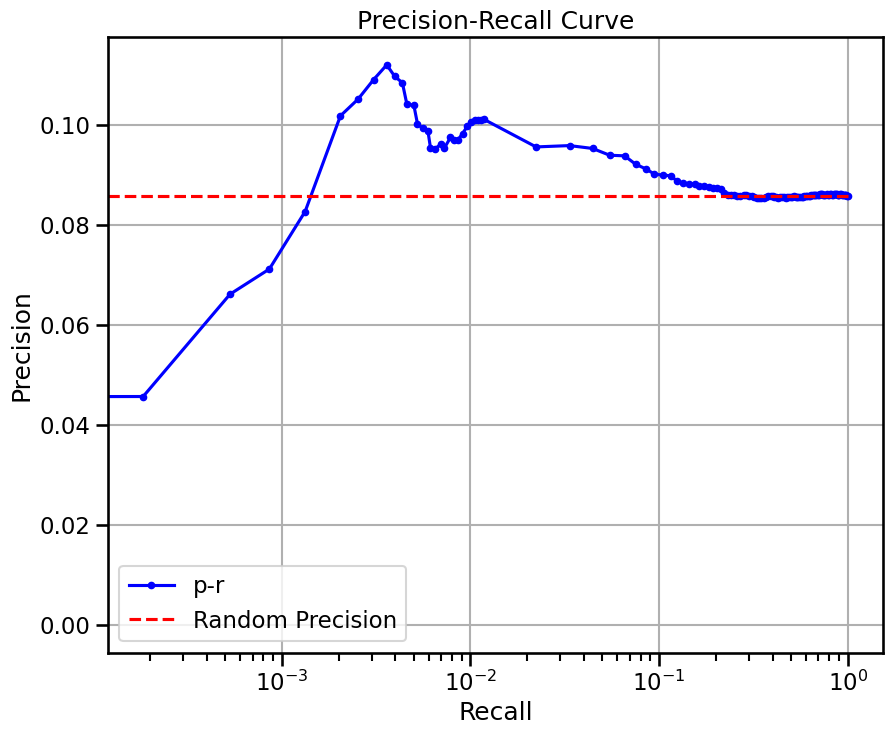

In [40]:
preadata = get_sroy_gt(get="tran", species="mouse", gt="ko")
metrics['scprint_mean_tran_ko'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

In [41]:
preadata = get_sroy_gt(get="tran", species="mouse", gt="full")

precision:  0.04013382246564018 
recall:  0.9996782496782497 
random precision: 0.04015140749544615



  0%|          | 0/128 [00:00<?, ?it/s]

/pasteur/appa/homes/jkalfon/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()

100%|██████████| 128/128 [00:00<00:00, 2145.25it/s]

Area Under Precision-Recall Curve (AUPRC):  0.0356590108035358
EPR: 0.6547159758965314


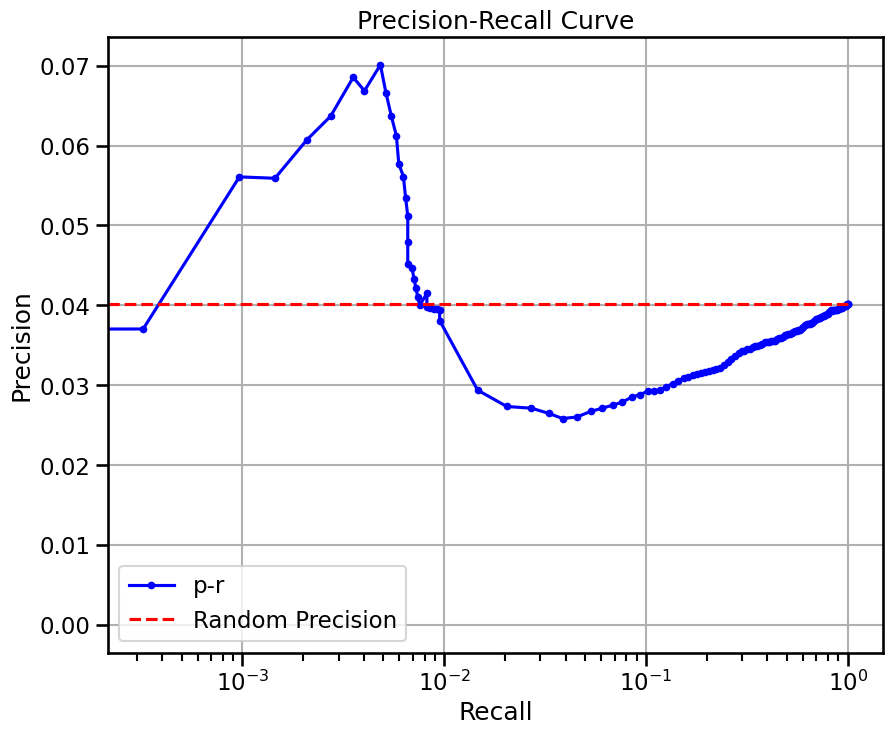

In [42]:
grn.varp["GRN"] = clf_omni.predict_proba(
    grn.varp['all'].reshape(-1, grn.varp['all'].shape[-1])
).reshape(len(grn.var), len(grn.var), 2)[:, :, 1]
metrics['scprint_omni_tran_full'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

precision:  0.2010054058149036 
recall:  0.9998654141207505 
random precision: 0.20105748519845437



  0%|          | 0/128 [00:00<?, ?it/s]


 55%|█████▍    | 70/128 [00:00<00:00, 691.69it/s]

/pasteur/appa/homes/jkalfon/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()

100%|██████████| 128/128 [00:00<00:00, 690.89it/s]

Area Under Precision-Recall Curve (AUPRC):  0.17416936483837775
EPR: 0.6119513689404721


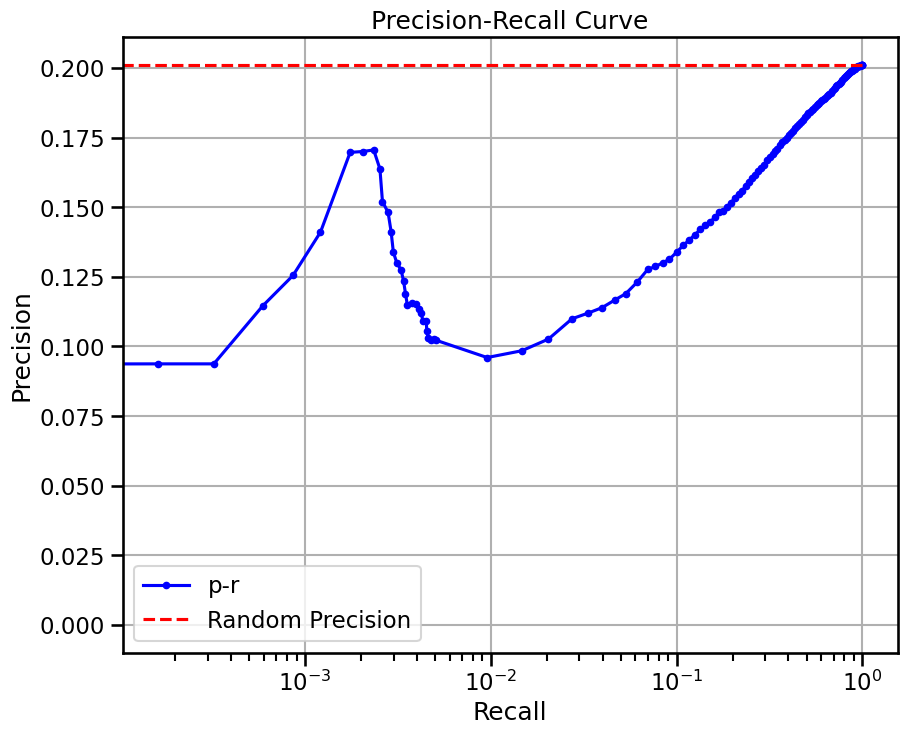

In [43]:
preadata = get_sroy_gt(get="tran", species="mouse", gt="chip")
metrics['scprint_omni_tran_chip'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

precision:  0.08577685828491946 
recall:  0.9998157625383828 
random precision: 0.08580472005002494



  0%|          | 0/128 [00:00<?, ?it/s]


 33%|███▎      | 42/128 [00:00<00:00, 413.12it/s]


 66%|██████▌   | 84/128 [00:00<00:00, 413.26it/s]


 98%|█████████▊| 126/128 [00:00<00:00, 413.78it/s]

/pasteur/appa/homes/jkalfon/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()

100%|██████████| 128/128 [00:00<00:00, 412.85it/s]

Area Under Precision-Recall Curve (AUPRC):  0.08251024455857169
EPR: 0.8769568170765991


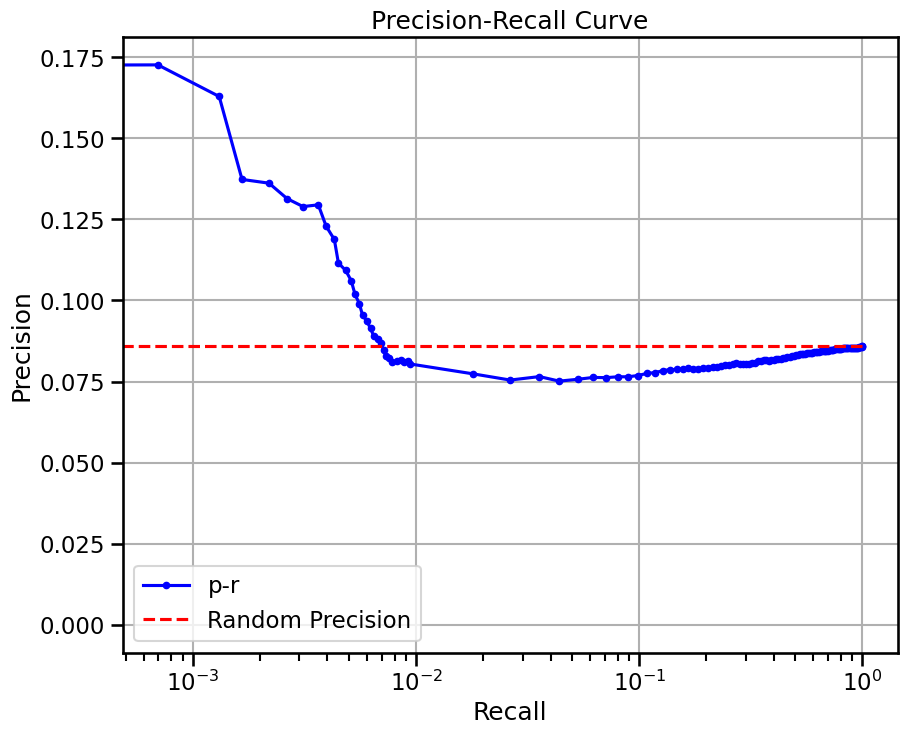

In [44]:
preadata = get_sroy_gt(get="tran", species="mouse", gt="ko")
metrics['scprint_omni_tran_ko'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

precision:  0.04014336917562724 
recall:  1.0 
random precision: 0.04015140749544615



  0%|          | 0/128 [00:00<?, ?it/s]

/pasteur/appa/homes/jkalfon/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()

100%|██████████| 128/128 [00:00<00:00, 2141.00it/s]

Area Under Precision-Recall Curve (AUPRC):  0.04089820945239863
EPR: 1.3272991920598602


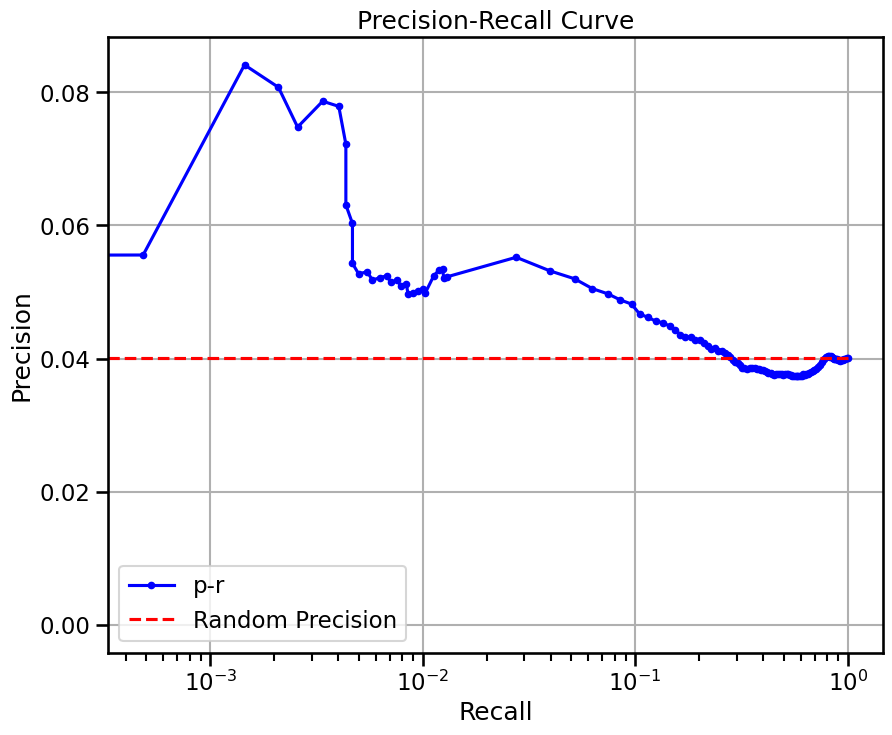

In [45]:
preadata = get_sroy_gt(get="tran", species="mouse", gt="full")
grn.varp["GRN"] = clf_self.predict_proba(
    grn.varp['all'].reshape(-1, grn.varp['all'].shape[-1])
).reshape(len(grn.var), len(grn.var), 2)[:, :, 1]
metrics['scprint_self_tran_full'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

precision:  0.20101723344966588 
recall:  1.0 
random precision: 0.20105748519845437



  0%|          | 0/128 [00:00<?, ?it/s]


 55%|█████▍    | 70/128 [00:00<00:00, 694.23it/s]

/pasteur/appa/homes/jkalfon/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()

100%|██████████| 128/128 [00:00<00:00, 692.41it/s]

Area Under Precision-Recall Curve (AUPRC):  0.20122042690914063
EPR: 1.0691377853583284


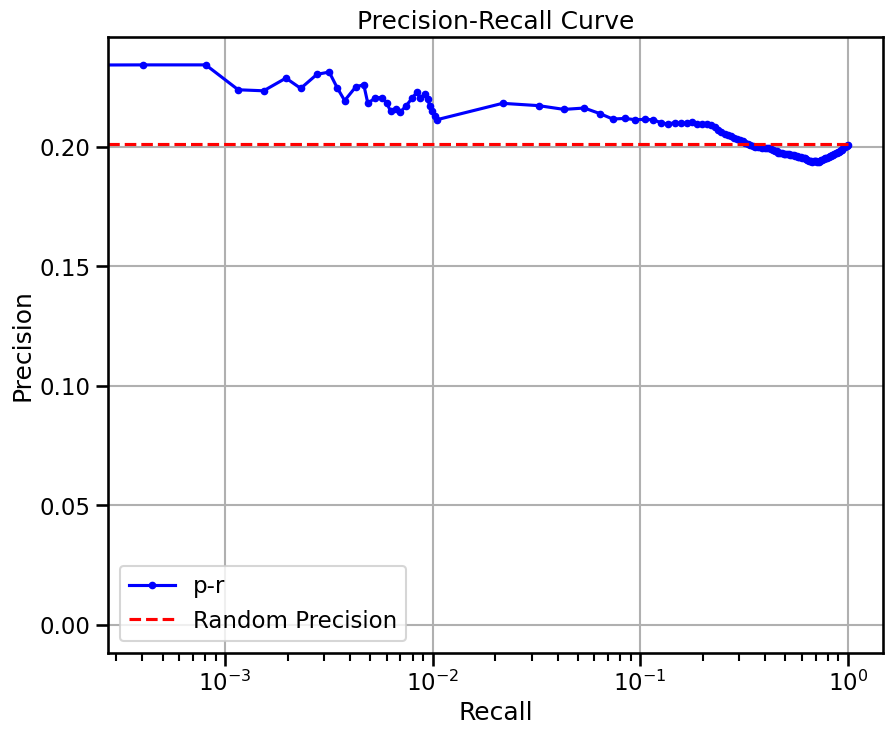

In [46]:
preadata = get_sroy_gt(get="tran", species="mouse", gt="chip")
metrics['scprint_self_tran_chip'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

precision:  0.0857875419278928 
recall:  1.0 
random precision: 0.08580472005002494



  0%|          | 0/128 [00:00<?, ?it/s]


 33%|███▎      | 42/128 [00:00<00:00, 413.46it/s]


 66%|██████▌   | 84/128 [00:00<00:00, 413.41it/s]


 98%|█████████▊| 126/128 [00:00<00:00, 413.94it/s]

/pasteur/appa/homes/jkalfon/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()

100%|██████████| 128/128 [00:00<00:00, 412.80it/s]

Area Under Precision-Recall Curve (AUPRC):  0.08746052818087165
EPR: 1.0898632627281222


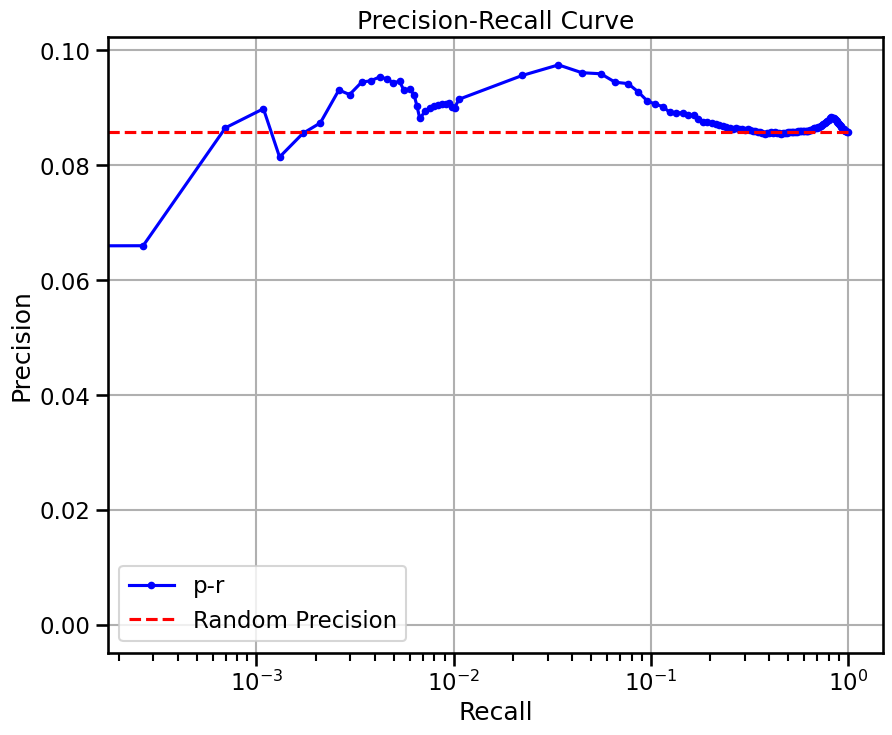

In [47]:
preadata = get_sroy_gt(get="tran", species="mouse", gt="ko")
metrics['scprint_self_tran_ko'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

In [48]:
del grn

## zhao / mouse

In [49]:
preadata = get_sroy_gt(get="zhao", species="mouse", gt="full")
adata = preprocessor(preadata.copy())
adata.var["isTF"] = False
adata.var.loc[adata.var.symbol.isin(grnutils.TF), "isTF"] = True
preadata, (preadata.grn.sum(1) != 0).sum()

Dropping layers:  KeysView(Layers with keys: )
checking raw counts


removed 0 non primary cells, 36199 renamining


filtered out 0 cells, 36199 renamining


Removed 0 genes.


startin QC


Seeing 828 outliers (2.29% of total dataset):


done


(GRnnData object with n_obs × n_vars = 36199 × 8442
     obs: 'organism_ontology_term_id'
     varp: 'GRN'
     with a grn of 9019 elements,
 34)

In [50]:
grn_inferer = GRNfer(model, adata,
                     how="most var within",
                     genes=adata.var[adata.var.symbol.isin(preadata.var[preadata.grn.sum(1) != 0].index.tolist())].index.tolist(),
                     preprocess="softmax",
                     head_agg='none',
                     filtration="none",
                     forward_mode="none",
                     organisms=['NCBITaxon:9606','NCBITaxon:10090'],
                     apc=False,
                     symmetrize=False,
                     num_genes=MAXGENES,
                     max_cells=MAXCELLS,
                     doplot=False,
                     batch_size=32,
                     )
grn = grn_inferer(layer=list(range(model.nlayers))[:])

Using 16bit Automatic Mixed Precision (AMP)


GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


number of expressed genes in this cell type: 8220


/pasteur/appa/homes/jkalfon/scPRINT/scprint/tasks/grn.py:165: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  organisms=[subadata.obs['organism_ontology_term_id'][0]],


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


SLURM auto-requeueing enabled. Setting signal handlers.


Predicting: |          | 0/? [00:00<?, ?it/s]

In [51]:
grn.varp["all"] = grn.varp['GRN']
grn.var['ensembl_id'] = grn.var.index
grn.var['symbol'] = make_index_unique(grn.var['symbol'].astype(str))
grn.var.index = grn.var['symbol']

precision:  0.0392254862760778 
recall:  1.0 
random precision: 0.03923332980462731



  0%|          | 0/128 [00:00<?, ?it/s]

/pasteur/appa/homes/jkalfon/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()

100%|██████████| 128/128 [00:00<00:00, 2032.82it/s]

Area Under Precision-Recall Curve (AUPRC):  0.04454522034329367
EPR: 1.2028627818952848


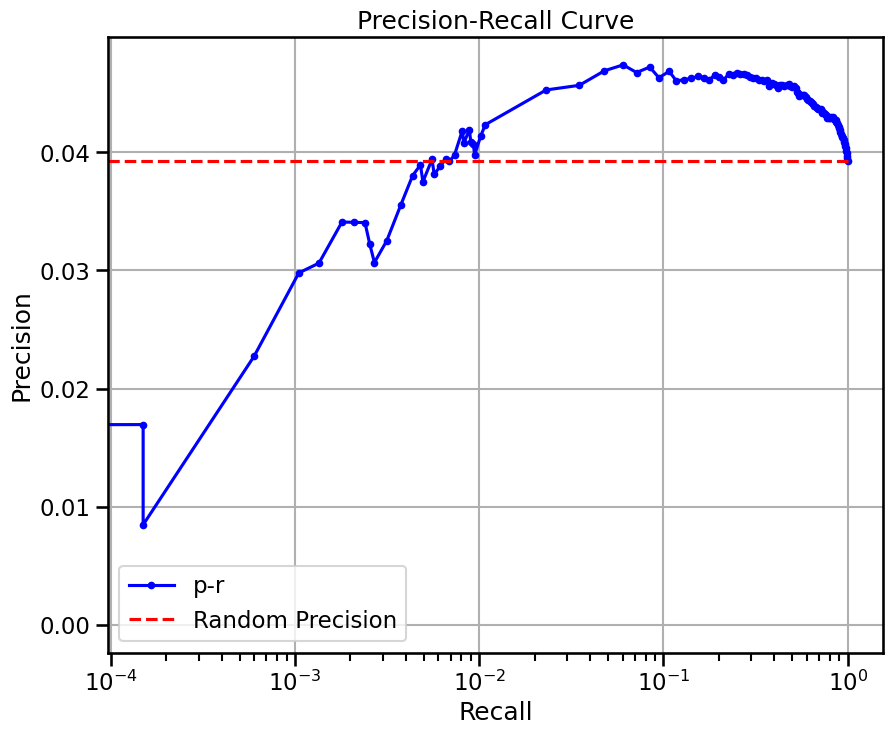

In [52]:
grn.varp['GRN'] = grn.varp['all'].mean(-1)
metrics['scprint_mean_zhao_full'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

precision:  0.0392254862760778 
recall:  1.0 
random precision: 0.03923332980462731



  0%|          | 0/128 [00:00<?, ?it/s]

/pasteur/appa/homes/jkalfon/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()

100%|██████████| 128/128 [00:00<00:00, 1986.64it/s]

Area Under Precision-Recall Curve (AUPRC):  0.03244733599003606
EPR: 0.4688755413376642


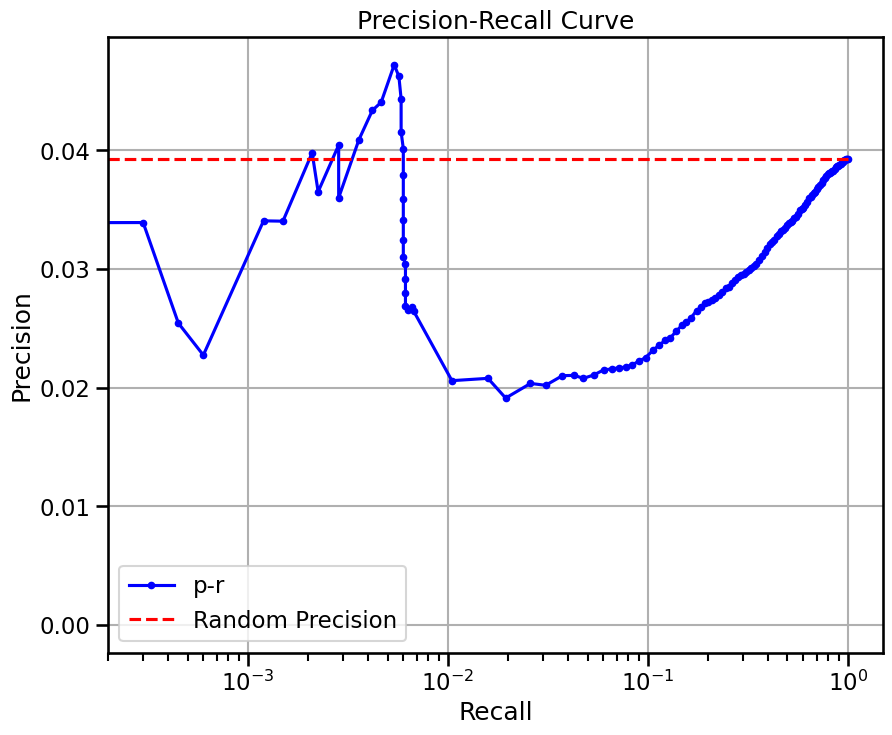

In [53]:
grn.varp["GRN"] = clf_omni.predict_proba(
    grn.varp['all'].reshape(-1, grn.varp['all'].shape[-1])
).reshape(len(grn.var), len(grn.var), 2)[:, :, 1]
metrics['scprint_omni_zhao_full'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

precision:  0.04670264983427216 
recall:  1.0 
random precision: 0.046715764872136314



  0%|          | 0/128 [00:00<?, ?it/s]

/pasteur/appa/homes/jkalfon/benGRN/bengrn/base.py:747: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()

100%|██████████| 128/128 [00:00<00:00, 2798.75it/s]

Area Under Precision-Recall Curve (AUPRC):  0.05064451759558501
EPR: 1.2430380189848078


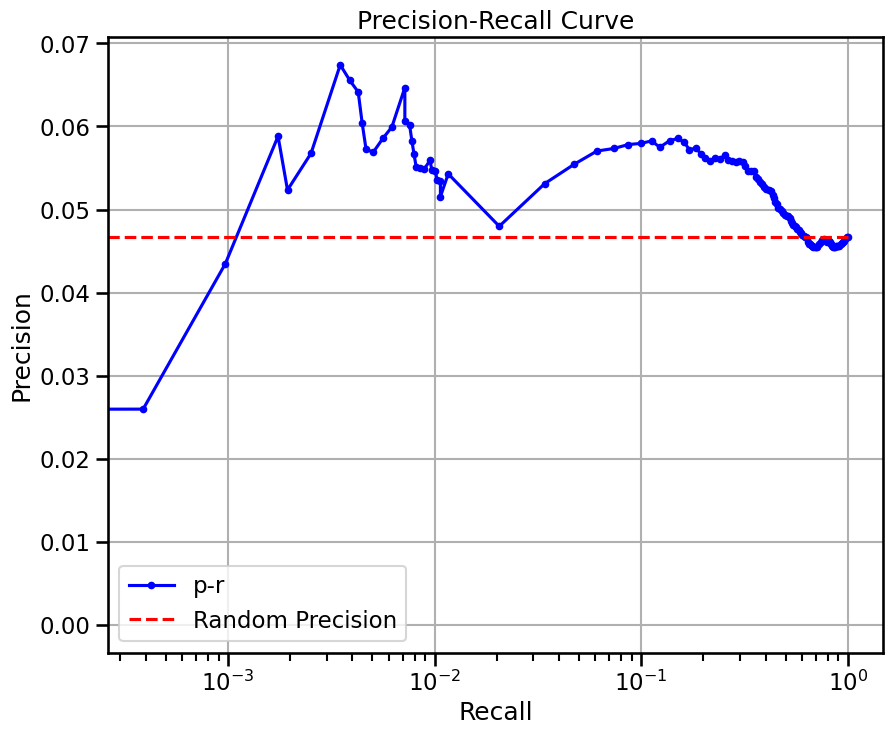

In [54]:
preadata = get_sroy_gt(get="tran", species="mouse", gt="full")
grn.varp["GRN"] = clf_self.predict_proba(
    grn.varp['all'].reshape(-1, grn.varp['all'].shape[-1])
).reshape(len(grn.var), len(grn.var), 2)[:, :, 1]
metrics['scprint_self_zhao_full'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

In [55]:
metrics

{'scprint_mean_han_full': {'precision': 0.038948387096774194,
  'recall': 1.0,
  'rand_precision': 0.03895617833244068,
  'auprc': 0.040911006732137586,
  'epr': 1.1764152910621384},
 'scprint_mean_han_base': {'TF_enr': True,
  'enriched_terms_Targets': ['celltype.gmt__Hepatic stellate cells',
   'celltype.gmt__Stromal cells',
   'celltype.gmt__Fibroblasts',
   'celltype.gmt__Mesenchymal stem cells',
   'celltype.gmt__Pancreatic stellate cells',
   'celltype.gmt__Podocytes',
   'celltype.gmt__Cholangiocytes',
   'celltype.gmt__Endothelial cells',
   'celltype.gmt__Acinar cells',
   'celltype.gmt__Myocytes',
   'celltype.gmt__Endothelial',
   'celltype.gmt__Perivascular cells',
   'celltype.gmt__Principal cells (Collecting duct system)',
   'celltype.gmt__Odontoblasts',
   'celltype.gmt__Enteroendocrine cells',
   'celltype.gmt__Pulmonary alveolar type I cells',
   'celltype.gmt__Smooth muscle cells',
   'celltype.gmt__Leydig cells',
   'celltype.gmt__Adipose progenitor cells',
   'cell

In [5]:
import pandas as pd

In [14]:
res = []
res2 = []
for k, v in metrics.items():
    if k.split('_')[-1] == "base":
        res2.append(["_".join(k.split('_')[-2:-1]), v['epr'], v['auprc'], v['rand_precision'], v['significant_enriched_TFtargets'], v.get('TF_enr', False), 'tf_' in k])
    elif k.split('_')[-1] == "ko":
        res.append(["_".join(k.split('_')[-3:-1])+"_ko", v['epr'], v['auprc'], v['rand_precision'], 'tf_' in k])
    elif k.split('_')[-1] == "chip":
        res.append(["_".join(k.split('_')[-3:-1])+"_chip", v['epr'], v['auprc'], v['rand_precision'], 'tf_' in k])
    else:
        res.append(["_".join(k.split('_')[1:]), v['epr'], v['auprc'], v['rand_precision'], 'tf_' in k])

df = pd.DataFrame(res, columns=['name','EPR', 'AUPRC', 'RAND', 'TF_only'])
df2 = pd.DataFrame(res2, columns=['name','EPR', 'AUPRC', 'RAND', 'TF_targ', 'TF_enr', 'TF_only'])
df

,name,EPR,AUPRC,RAND,TF_only
0,mean_han_full,1.176415,0.040911,0.038956,False
1,mean_han_chip,1.062011,0.271109,0.264245,False
2,mean_han_ko,1.096315,0.086254,0.082725,False
3,omni_han_full,0.528588,0.035703,0.038956,False
4,omni_han_chip,0.766553,0.244347,0.264245,False
5,omni_han_ko,0.733005,0.077614,0.082725,False
6,self_han_full,1.288291,0.092830,0.082725,False
7,self_han_chip,0.964424,0.259300,0.264245,False
8,self_han_ko,1.288291,0.092830,0.082725,False
9,mean_mine_full,0.966846,0.027547,0.027030,False


In [13]:
df2

,name,EPR,AUPRC,RAND,TF_targ,TF_enr,TF_only
0,mean_han,2.032131,0.001806,0.001616,23.636364,True,False
1,omni_han,5.116868,0.001660,0.001616,3.636364,True,False
2,self_han,1.053383,0.001710,0.001616,30.909091,True,False
3,mean_mine,1.798590,0.001845,0.001595,31.111111,False,False
4,omni_mine,1.945328,0.001671,0.001595,13.333333,True,False
